# OLA Driver

**Column Profiling:**

1. MMMM-YY : Reporting Date (Monthly)
2. Driver\_ID : Unique id for drivers
3. Age : Age of the driver
4. Gender : Gender of the driver – Male : 0, Female: 1
5. City : City Code of the driver
6. Education\_Level : Education level – 0 for 10+ ,1 for 12+ ,2 for graduate
7. Income : Monthly average Income of the driver
8. Date Of Joining : Joining date for the driver
9. LastWorkingDate : Last date of working for the driver
10. Joining Designation : Designation of the driver at the time of joining
11. Grade : Grade of the driver at the time of reporting
12. Total Business Value : The total business value acquired by the driver in a month (negative business indicates cancellation/refund or car EMI adjustments)
13. Quarterly Rating : Quarterly rating of the driver: 1,2,3,4,5 (higher is better)

tenure
salary-revenue per driver
has neg business value
pct change

https://chatgpt.com/share/fe0790c8-5a45-4cfc-a369-48a1999ab5e6

In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as sf
from pyspark.sql.window import Window
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from IPython.display import clear_output

sns.set_theme(style="whitegrid")

In [2]:
os.environ['PYSPARK_PIN_THREAD'] = 'false'

spark = SparkSession.builder \
    .appName("OLA") \
    .config("spark.sql.debug.maxToStringFields", 1000) \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.sql.shuffle.partitions", 1) \
    .config("spark.network.timeout", "120s") \
    .config("spark.executor.heartbeatInterval", "10s") \
    .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:1.0.4,org.mlflow:mlflow-spark_2.13:2.15.1")   \
    .master("local[16]") \
    .getOrCreate();
clear_output()

In [3]:
spark.sparkContext.setLogLevel("ERROR")
cores = spark._jsc.sc().getExecutorMemoryStatus().keySet().size()
print("You are working with", cores, "core(s)")
spark

You are working with 1 core(s)


In [15]:
spark_df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .option("multiLine", "true") \
    .option("escape", "\"") \
    .csv("./ola_driver_scaler.csv")
spark_df.cache();

In [16]:
spark_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- MMM-YY: string (nullable = true)
 |-- Driver_ID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: integer (nullable = true)
 |-- City: string (nullable = true)
 |-- Education_Level: integer (nullable = true)
 |-- Income: integer (nullable = true)
 |-- Dateofjoining: string (nullable = true)
 |-- LastWorkingDate: string (nullable = true)
 |-- Joining Designation: integer (nullable = true)
 |-- Grade: integer (nullable = true)
 |-- Total Business Value: integer (nullable = true)
 |-- Quarterly Rating: integer (nullable = true)



In [17]:
spark_df = spark_df.drop('_c0');
spark_df.show();

+--------+---------+---+------+----+---------------+------+-------------+---------------+-------------------+-----+--------------------+----------------+
|  MMM-YY|Driver_ID|Age|Gender|City|Education_Level|Income|Dateofjoining|LastWorkingDate|Joining Designation|Grade|Total Business Value|Quarterly Rating|
+--------+---------+---+------+----+---------------+------+-------------+---------------+-------------------+-----+--------------------+----------------+
|01/01/19|        1| 28|     0| C23|              2| 57387|     24/12/18|           NULL|                  1|    1|             2381060|               2|
|02/01/19|        1| 28|     0| C23|              2| 57387|     24/12/18|           NULL|                  1|    1|             -665480|               2|
|03/01/19|        1| 28|     0| C23|              2| 57387|     24/12/18|       03/11/19|                  1|    1|                   0|               2|
|11/01/20|        2| 31|     0|  C7|              2| 67016|     11/06/20|   

In [18]:
spark_df.select([sf.count(sf.when(sf.isnull(c), c)).alias(c) for c in spark_df.columns]).toPandas().T

,0
MMM-YY,0
Driver_ID,0
Age,61
Gender,52
City,0
Education_Level,0
Income,0
Dateofjoining,0
LastWorkingDate,17488
Joining Designation,0


# Data Cleaning

In [18]:
spark_df = spark_df.withColumn("reporting_month_year", sf.to_date(spark_df["MMM-YY"], "MM/dd/yy")).drop("MMM-YY")
spark_df = spark_df.withColumn("Dateofjoining", sf.to_date(spark_df["Dateofjoining"], "dd/MM/yy"))
spark_df = spark_df.withColumn("LastWorkingDate", sf.to_date(spark_df["LastWorkingDate"], "dd/MM/yy"))
spark_df = spark_df.withColumn("Quarter", sf.quarter(spark_df["reporting_month_year"]))

In [19]:
spark_df=spark_df.dropDuplicates()

In [29]:
spark_df.filter(sf.col("Age").isNull()).show()

+---------+----+------+----+---------------+------+-------------+---------------+-------------------+-----+--------------------+----------------+--------------------+-------+
|Driver_ID| Age|Gender|City|Education_Level|Income|Dateofjoining|LastWorkingDate|Joining Designation|Grade|Total Business Value|Quarterly Rating|reporting_month_year|Quarter|
+---------+----+------+----+---------------+------+-------------+---------------+-------------------+-----+--------------------+----------------+--------------------+-------+
|       20|NULL|     1| C19|              0| 40342|   2019-10-25|           NULL|                  3|    3|                   0|               1|          2020-02-01|      1|
|       22|NULL|     0| C10|              2| 31224|   2018-05-25|           NULL|                  1|    1|              200000|               3|          2019-10-01|      4|
|       24|NULL|     0| C24|              2| 76308|   2018-05-25|           NULL|                  1|    2|              2032

In [20]:
spark_df.filter("Driver_ID == 2").sort("reporting_month_year").show()

+---------+---+------+----+---------------+------+-------------+---------------+-------------------+-----+--------------------+----------------+--------------------+-------+
|Driver_ID|Age|Gender|City|Education_Level|Income|Dateofjoining|LastWorkingDate|Joining Designation|Grade|Total Business Value|Quarterly Rating|reporting_month_year|Quarter|
+---------+---+------+----+---------------+------+-------------+---------------+-------------------+-----+--------------------+----------------+--------------------+-------+
|        2| 31|     0|  C7|              2| 67016|   2020-06-11|           NULL|                  2|    2|                   0|               1|          2020-11-01|      4|
|        2| 31|     0|  C7|              2| 67016|   2020-06-11|           NULL|                  2|    2|                   0|               1|          2020-12-01|      4|
+---------+---+------+----+---------------+------+-------------+---------------+-------------------+-----+--------------------+---

In [22]:
window_spec = Window.partitionBy("Driver_ID")

spark_df=spark_df.withColumns({
    "Age":  sf.coalesce(sf.col("Age"), sf.first("Age", True).over(window_spec)),
    "Gender":  sf.coalesce(sf.col("Gender"), sf.first("Age", True).over(window_spec)),
    "LastWorkingDate":  sf.coalesce(sf.col("LastWorkingDate"), sf.first("LastWorkingDate", True).over(window_spec)),
    "Churned":  sf.when(sf.col("LastWorkingDate").isNotNull(), 1).otherwise(0),
    "Had_Negative_Business":  sf.when(sf.col("Total Business Value") > 0, 1).otherwise(0)
})

In [51]:
spark_df.createOrReplaceTempView("ola")

In [35]:
spark.sql(""" 
    select 
          Driver_Id
          , max(reporting_month_year) as max_reporting_month_year
          , max(Dateofjoining) as max_Dateofjoining
          , max(LastWorkingDate) as max_LastWorkingDate
        from ola 
        group by Driver_Id
          having max_LastWorkingDate < max_Dateofjoining
""").show()

+---------+------------------------+-----------------+-------------------+
|Driver_Id|max_reporting_month_year|max_Dateofjoining|max_LastWorkingDate|
+---------+------------------------+-----------------+-------------------+
|        5|              2019-03-01|       2019-09-01|         2019-07-03|
|       18|              2019-05-01|       2019-09-01|         2019-04-30|
|       35|              2020-05-01|       2020-07-03|         2020-05-05|
|       59|              2019-03-01|       2019-06-01|         2019-03-28|
|       82|              2020-08-01|       2020-11-04|         2020-07-29|
|      102|              2019-03-01|       2019-05-01|         2019-03-21|
|      108|              2020-06-01|       2020-09-01|         2020-02-06|
|      118|              2020-09-01|       2020-10-03|         2020-09-15|
|      121|              2020-05-01|       2020-07-03|         2020-05-24|
|      139|              2019-12-01|       2019-10-31|         2019-05-12|
|      147|              

In [27]:
spark.sql("""
          select 
          Driver_ID
          , max(`Quarterly Rating`) as max_qr
          , min(`Quarterly Rating`) as min_qr
          , avg(`Quarterly Rating`) as avg_qr 
          , count(*) as count_qr
          from ola 
          group by Driver_ID 
          order by count_qr desc
           """).show()

+---------+------+------+------+--------+
|Driver_ID|max_qr|min_qr|avg_qr|count_qr|
+---------+------+------+------+--------+
|       56|     4|     2| 2.875|      24|
|       60|     4|     2|   3.5|      24|
|      486|     3|     1| 1.875|      24|
|       63|     3|     1| 1.875|      24|
|     1472|     3|     1|  1.75|      24|
|       67|     3|     1|   2.5|      24|
|     1664|     2|     2|   2.0|      24|
|       68|     4|     3|  3.25|      24|
|     2168|     3|     2| 2.625|      24|
|       77|     4|     2|   3.0|      24|
|     2545|     3|     1|   2.0|      24|
|       78|     4|     2| 2.625|      24|
|       25|     4|     3|  3.75|      24|
|      112|     4|     2| 2.875|      24|
|      173|     4|     2|  2.75|      24|
|      115|     3|     2| 2.125|      24|
|     1612|     4|     1|  2.25|      24|
|      117|     4|     2|   2.5|      24|
|      199|     4|     2|  3.25|      24|
|      140|     3|     2| 2.625|      24|
+---------+------+------+------+--

In [53]:
spark_df.filter("`Total Business Value` = 0").show()

+---------+---+------+----+---------------+------+-------------+---------------+-------------------+-----+--------------------+----------------+--------------------+-------+-------+---------------------+
|Driver_ID|Age|Gender|City|Education_Level|Income|Dateofjoining|LastWorkingDate|Joining Designation|Grade|Total Business Value|Quarterly Rating|reporting_month_year|Quarter|Churned|Had_Negative_Business|
+---------+---+------+----+---------------+------+-------------+---------------+-------------------+-----+--------------------+----------------+--------------------+-------+-------+---------------------+
|        1| 28|     0| C23|              2| 57387|   2018-12-24|     2019-11-03|                  1|    1|                   0|               2|          2019-03-01|      1|      1|                    0|
|        2| 31|     0|  C7|              2| 67016|   2020-06-11|           NULL|                  2|    2|                   0|               1|          2020-11-01|      4|      0|   

In [28]:
spark_df.select(sf.max("LastWorkingDate")).show()

+--------------------+
|max(LastWorkingDate)|
+--------------------+
|          2020-12-28|
+--------------------+



In [29]:
spark_df.select(sf.max("reporting_month_year")).show()

+-------------------------+
|max(reporting_month_year)|
+-------------------------+
|               2020-12-01|
+-------------------------+



In [23]:
spark_df.columns

['Driver_ID',
 'Age',
 'Gender',
 'City',
 'Education_Level',
 'Income',
 'Dateofjoining',
 'LastWorkingDate',
 'Joining Designation',
 'Grade',
 'Total Business Value',
 'Quarterly Rating',
 'reporting_month_year',
 'Quarter',
 'Churned',
 'Had_Negative_Business']

In [24]:
agg_map=[
    sf.first("Dateofjoining").alias("Date_Of_Joining"),
    sf.sum("Total Business Value").alias("Total_Business_Value"),
    sf.sum("Had_Negative_Business").alias("Total_Had_Negative_Business"),
    sf.avg("Total Business Value").cast("int").alias("Avg_Business_Value"), 
    sf.max("reporting_month_year").alias("Last_Reporting_Month"),
    sf.max("Age").alias("Age"),
    sf.first("Gender").alias("Gender"),
    sf.first("Income").alias("Income"),
    sf.sum("Income").alias("Total_Income"),
    sf.first("Education_Level").alias("Education_Level"),
    sf.first("City").alias("City"),
    sf.first("Joining Designation").alias("Joining_Designation"),
    sf.min("Grade").alias("Min_Grade"),
    sf.max("Grade").alias("Max_Grade"),
    sf.round(sf.avg("Grade"), 1).alias("Avg_Grade"),    
    sf.mode("Grade").alias("Mode_Grade"),
    sf.min("Quarterly Rating").alias("Min_Quarterly_Rating"),
    sf.max("Quarterly Rating").alias("Max_Quarterly_Rating"),
    sf.round(sf.avg("Quarterly Rating"), 1).alias("Avg_Quarterly_Rating"),
    sf.mode("Quarterly Rating").alias("Mode_Quarterly_Rating"),
    sf.max("LastWorkingDate").alias("Last_Working_Date"),
    sf.max("churned").alias("Churned"),
]


merged_df = spark_df.groupBy("Driver_ID").agg(*agg_map)

default_date = "2020-12-31"

merged_df = merged_df.withColumn(
    "Tenure",
      sf.abs(
        sf.datediff(
            sf.when(sf.col("Last_Working_Date").isNull(), sf.lit(default_date)).otherwise(sf.col("Last_Working_Date")),
            sf.col("Date_Of_Joining")
        )
    )
)


merged_df=merged_df.withColumn("Date_Of_Joining_month", sf.month(merged_df["Date_Of_Joining"]))
merged_df=merged_df.withColumn("Date_Of_Joining_year", sf.year(merged_df["Date_Of_Joining"]))
merged_df=merged_df.withColumn("Is_Valuable_Driver", sf.when(merged_df["Total_Business_Value"] > merged_df["Total_Income"], 1).otherwise(0))

merged_df.show()

+---------+---------------+--------------------+---------------------------+------------------+--------------------+---+------+------+------------+---------------+----+-------------------+---------+---------+---------+----------+--------------------+--------------------+--------------------+---------------------+-----------------+-------+------+---------------------+--------------------+------------------+
|Driver_ID|Date_Of_Joining|Total_Business_Value|Total_Had_Negative_Business|Avg_Business_Value|Last_Reporting_Month|Age|Gender|Income|Total_Income|Education_Level|City|Joining_Designation|Min_Grade|Max_Grade|Avg_Grade|Mode_Grade|Min_Quarterly_Rating|Max_Quarterly_Rating|Avg_Quarterly_Rating|Mode_Quarterly_Rating|Last_Working_Date|Churned|Tenure|Date_Of_Joining_month|Date_Of_Joining_year|Is_Valuable_Driver|
+---------+---------------+--------------------+---------------------------+------------------+--------------------+---+------+------+------------+---------------+----+------------

In [32]:
spark_df.show()

+---------+---+------+----+---------------+------+-------------+---------------+-------------------+-----+--------------------+----------------+--------------------+-------+-------+
|Driver_ID|Age|Gender|City|Education_Level|Income|Dateofjoining|LastWorkingDate|Joining Designation|Grade|Total Business Value|Quarterly Rating|reporting_month_year|Quarter|Churned|
+---------+---+------+----+---------------+------+-------------+---------------+-------------------+-----+--------------------+----------------+--------------------+-------+-------+
|        1| 28|     0| C23|              2| 57387|   2018-12-24|     2019-11-03|                  1|    1|                   0|               2|          2019-03-01|      1|      1|
|        1| 28|     0| C23|              2| 57387|   2018-12-24|     2019-11-03|                  1|    1|             2381060|               2|          2019-01-01|      1|      1|
|        1| 28|     0| C23|              2| 57387|   2018-12-24|     2019-11-03|          

In [25]:
spark_df.write.parquet("ola_driver_cleaned.parquet", mode='overwrite')
merged_df.write.parquet("ola_driver_merged.parquet", mode='overwrite')

# EDA

In [27]:
ola_df = spark.read.parquet("ola_driver_cleaned.parquet")
merged_df = spark.read.parquet("ola_driver_merged.parquet")
ola_df.createOrReplaceTempView("ola_driver")
merged_df.createOrReplaceTempView("ola_driver_merged")
ola_df=ola_df.toPandas()
merged_df=merged_df.toPandas()

In [64]:
ola_df=pd.read_parquet("ola_driver_cleaned.parquet")
merged_df=pd.read_parquet("ola_driver_merged.parquet")

In [28]:
merged_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Driver_ID,2381.0,1.397559e+03,8.061616e+02,1.0,695.0,1400.0,2100.0,2788.0
Total_Business_Value,2381.0,4.586742e+06,9.127115e+06,-1385530.0,0.0,817680.0,4173650.0,95331060.0
Total_Had_Negative_Business,2381.0,5.231415e+00,6.956693e+00,0.0,0.0,2.0,7.0,24.0
Avg_Business_Value,2381.0,3.120852e+05,4.495704e+05,-197932.0,0.0,150624.0,429498.0,3972127.0
Age,2381.0,3.366317e+01,5.983375e+00,21.0,29.0,33.0,37.0,58.0
Gender,2381.0,4.103318e-01,4.919972e-01,0.0,0.0,0.0,1.0,1.0
Income,2381.0,5.921868e+04,2.828788e+04,10747.0,39104.0,55276.0,75765.0,188418.0
Total_Income,2381.0,5.267603e+05,6.231633e+05,10883.0,139895.0,292980.0,651456.0,4522032.0
Education_Level,2381.0,1.007560e+00,8.162900e-01,0.0,0.0,1.0,2.0,2.0
Joining_Designation,2381.0,1.820244e+00,8.414334e-01,1.0,1.0,2.0,2.0,5.0


In [29]:
merged_df[merged_df["Tenure"]==0]

,Driver_ID,Date_Of_Joining,Total_Business_Value,Total_Had_Negative_Business,Avg_Business_Value,Last_Reporting_Month,Age,Gender,Income,Total_Income,...,Min_Quarterly_Rating,Max_Quarterly_Rating,Avg_Quarterly_Rating,Mode_Quarterly_Rating,Last_Working_Date,Churned,Tenure,Date_Of_Joining_month,Date_Of_Joining_year,Is_Valuable_Driver
220,264,2020-12-18,0,0,0,2020-12-01,25,0,49439,49439,...,1,1,1.0,1,2020-12-18,1,0,12,2020,0
1026,1207,2020-12-04,0,0,0,2020-04-01,28,0,56498,56498,...,1,1,1.0,1,2020-12-04,1,0,12,2020,0
1344,1581,2019-06-30,0,0,0,2019-07-01,29,0,25873,25873,...,1,1,1.0,1,2019-06-30,1,0,6,2019,0
2041,2397,2020-05-15,0,0,0,2020-05-01,38,1,47818,47818,...,1,1,1.0,1,2020-05-15,1,0,5,2020,0


## Outlier Check

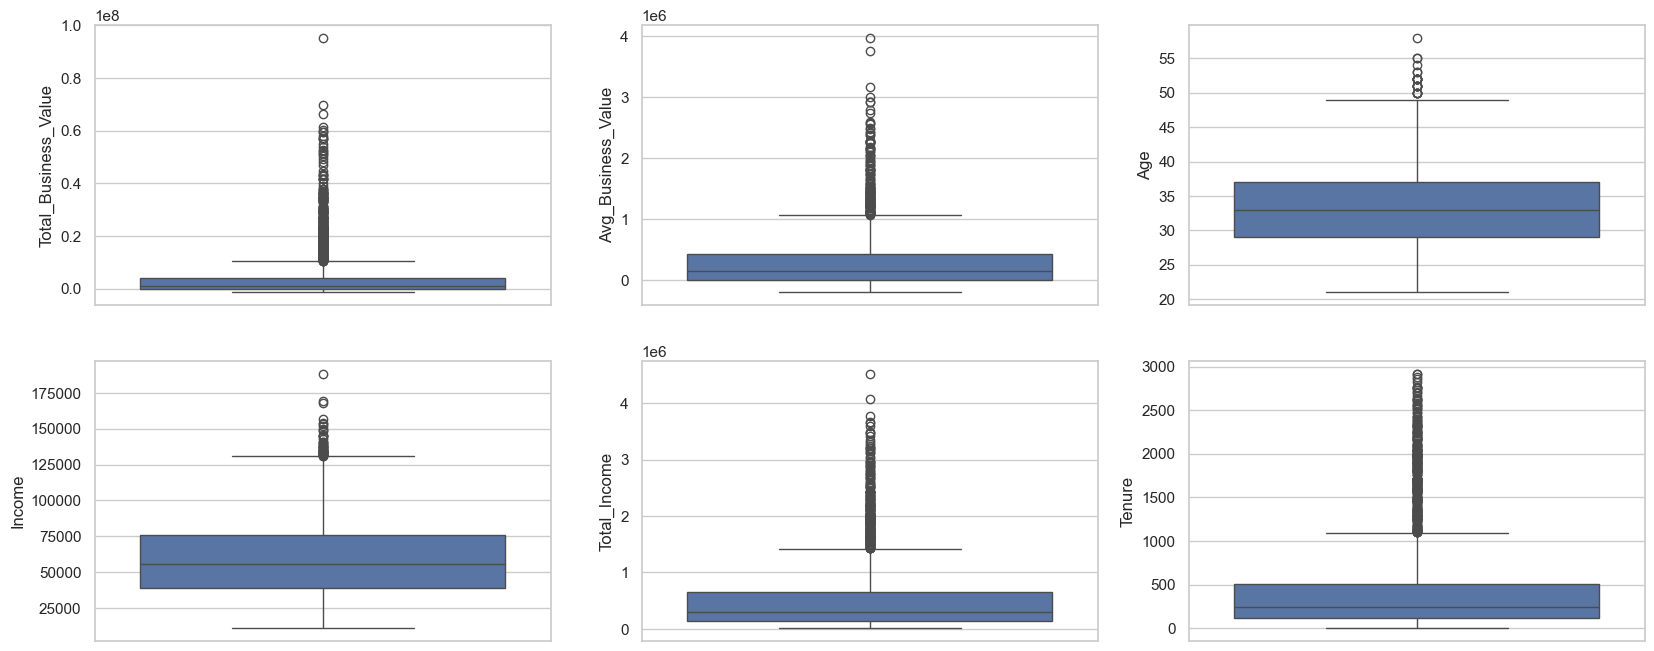

In [9]:
numerical_cols = ['Total_Business_Value', 'Avg_Business_Value', 'Age','Income', 'Total_Income', 'Tenure']

fig, ax = plt.subplots(2, 3, figsize=(20, 8))
for i, col in enumerate(numerical_cols):
    sns.boxplot(merged_df[col], ax=ax[i//3, i%3])

<b style='padding: 2px 8px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- From above plot we can see there are not any drastic outliers

## Univariate Analysis

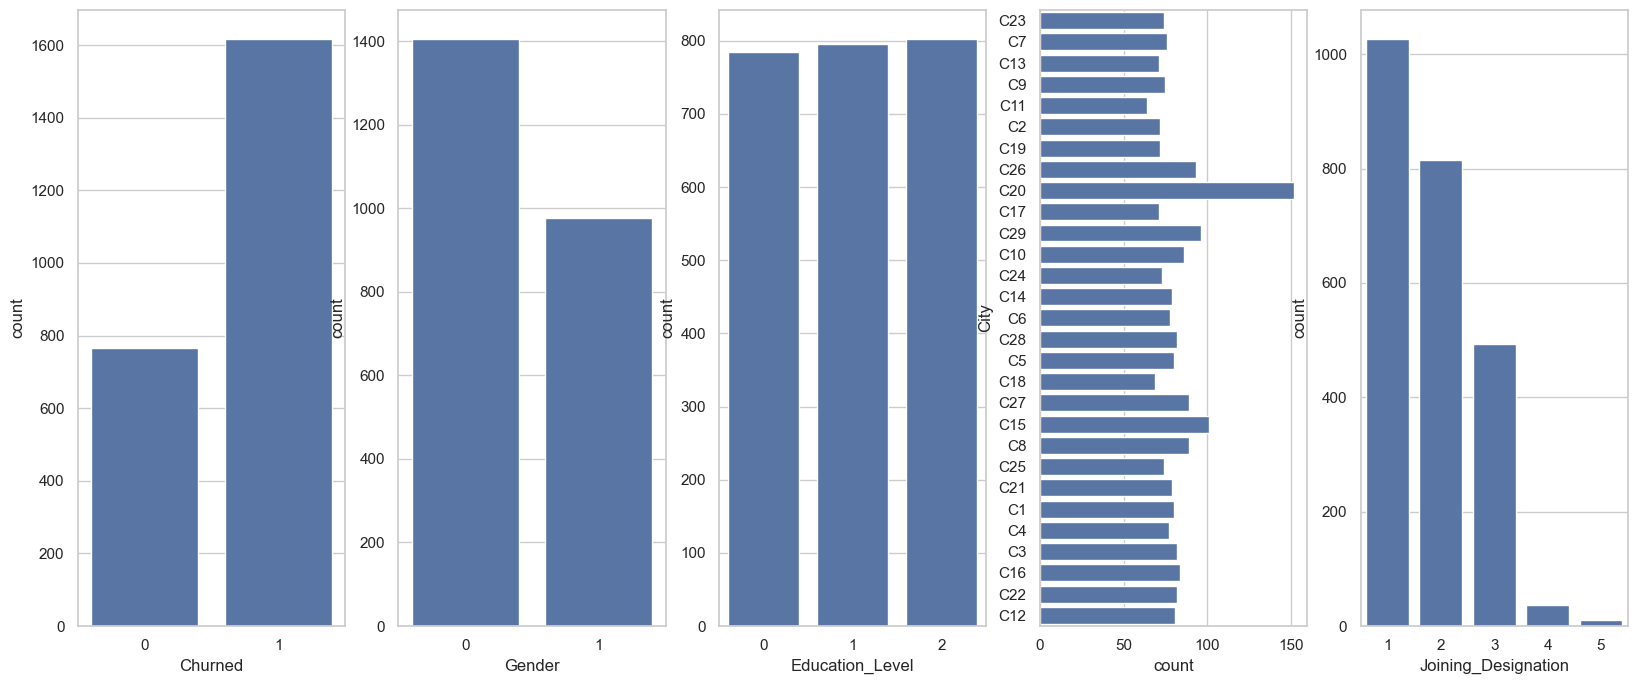

In [11]:
fig, ax = plt.subplots(1, 5, figsize=(20, 8))

sns.countplot(data=merged_df, x="Churned", ax=ax[0])
sns.countplot(data=merged_df, x="Gender", ax=ax[1])
sns.countplot(data=merged_df, x="Education_Level", ax=ax[2])
sns.countplot(data=merged_df, y="City", ax=ax[3])
sns.countplot(data=merged_df, x="Joining_Designation", ax=ax[4]);


<b style='padding: 2px 8px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>
- We can see that 1600 drivers have left

<Axes: xlabel='Tenure', ylabel='Count'>

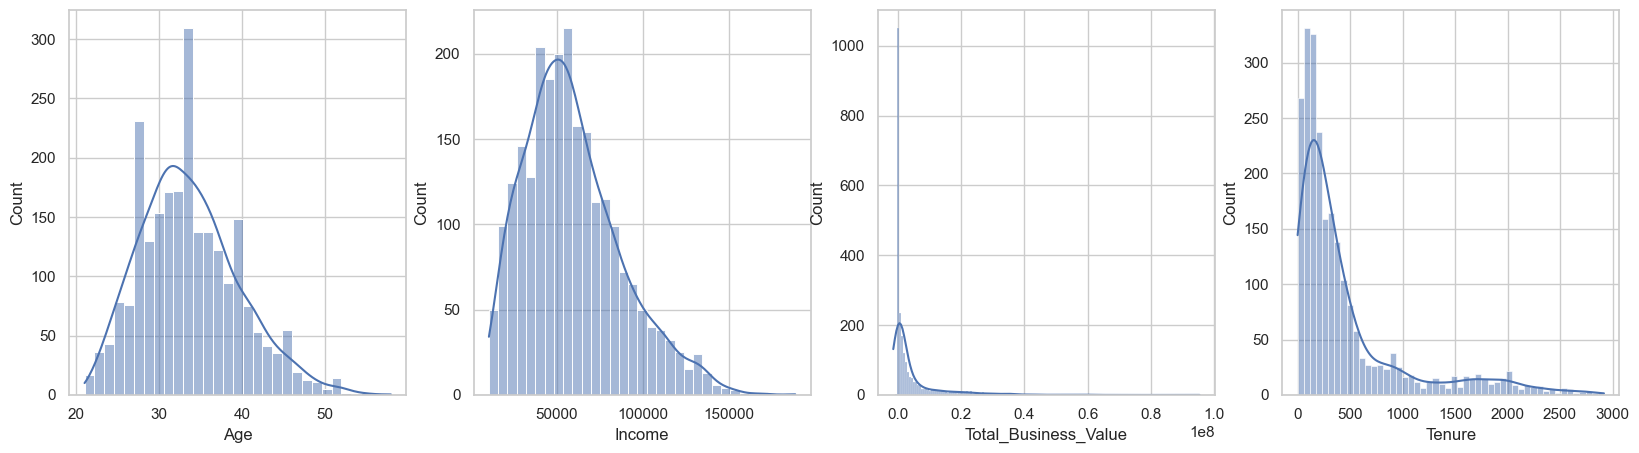

In [38]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

sns.histplot(merged_df["Age"], kde=True, ax=ax[0])
sns.histplot(merged_df["Income"], kde=True, ax=ax[1])
sns.histplot(merged_df["Total_Business_Value"], kde=True, ax=ax[2])
sns.histplot(merged_df["Tenure"], kde=True, ax=ax[3]);

## Bivariate Analysis

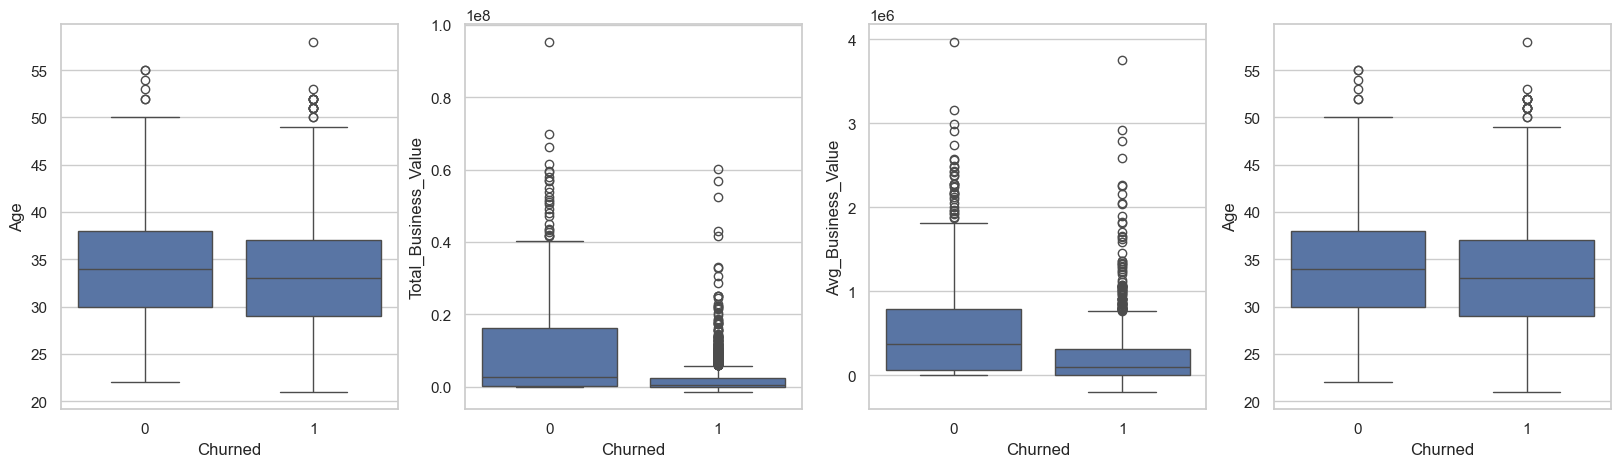

In [18]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

sns.boxplot(data=merged_df, x="Churned", y="Age", ax=ax[0]);
sns.boxplot(data=merged_df, x="Churned", y="Total_Business_Value", ax=ax[1]);
sns.boxplot(data=merged_df, x="Churned", y="Avg_Business_Value", ax=ax[2]);
sns.boxplot(data=merged_df, x="Churned", y="Age", ax=ax[3]);

In [17]:
merged_df.columns

Index(['Driver_ID', 'Date_Of_Joining', 'Total_Business_Value',
       'Avg_Business_Value', 'Last_Reporting_Month', 'Age', 'Gender', 'Income',
       'Total_Income', 'Education_Level', 'City', 'Joining_Designation',
       'Min_Grade', 'Max_Grade', 'Avg_Grade', 'Mode_Grade',
       'Min_Quarterly_Rating', 'Max_Quarterly_Rating', 'Avg_Quarterly_Rating',
       'Mode_Quarterly_Rating', 'Last_Working_Date', 'Churned', 'Tenure'],
      dtype='object')

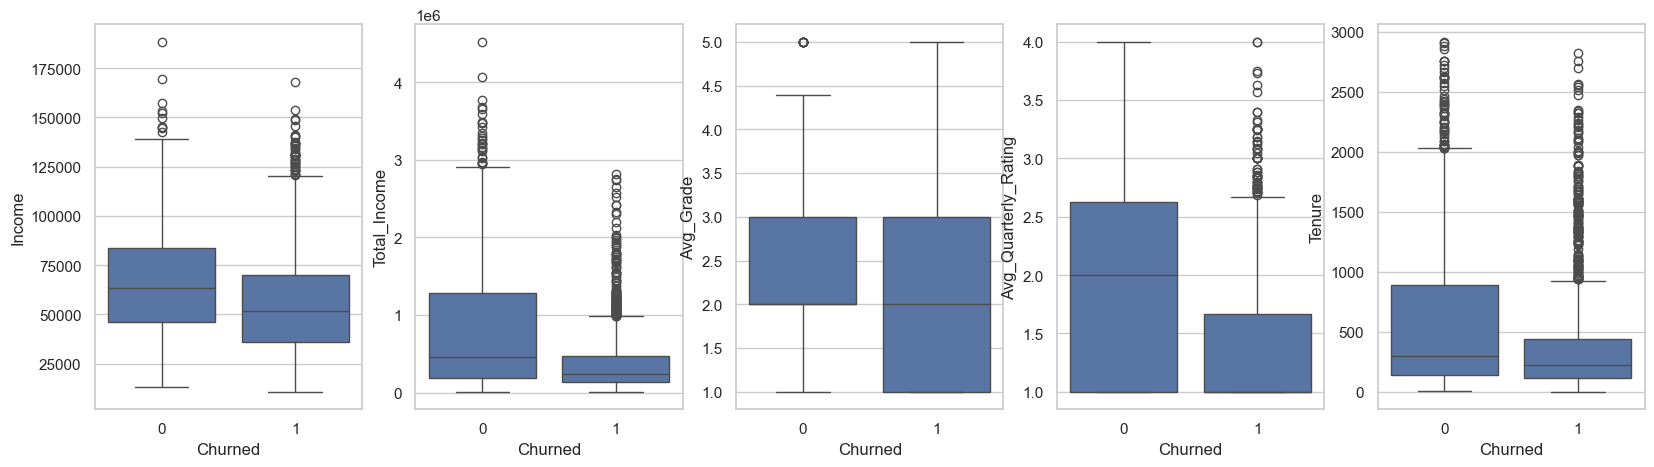

In [24]:
fig, ax = plt.subplots(1, 5, figsize=(20, 5))

sns.boxplot(data=merged_df, x="Churned", y="Income", ax=ax[0]);
sns.boxplot(data=merged_df, x="Churned", y="Total_Income", ax=ax[1]);
sns.boxplot(data=merged_df, x="Churned", y="Avg_Grade", ax=ax[2]);
sns.boxplot(data=merged_df, x="Churned", y="Avg_Quarterly_Rating", ax=ax[3]);
sns.boxplot(data=merged_df, x="Churned", y="Tenure", ax=ax[4]);

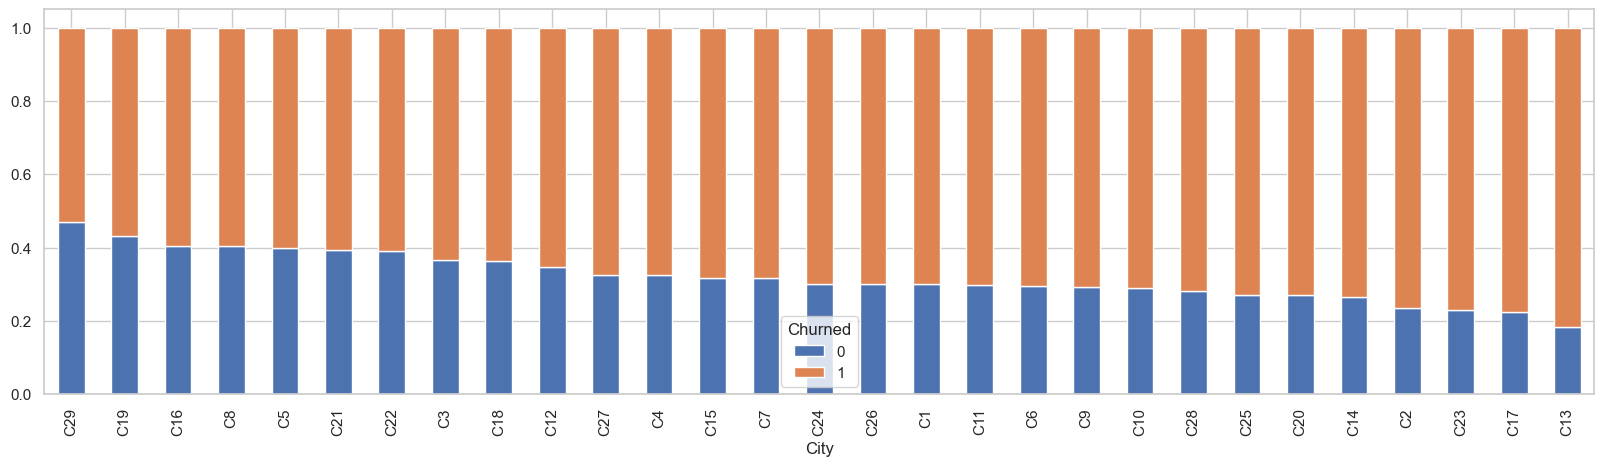

In [13]:
pd.crosstab(merged_df["City"], merged_df["Churned"],  normalize="index").sort_values(1).plot(kind="bar", stacked=True, figsize=(20, 5));



<b style='padding: 2px 8px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- Above plot shows the ratio of churned drivers in each city

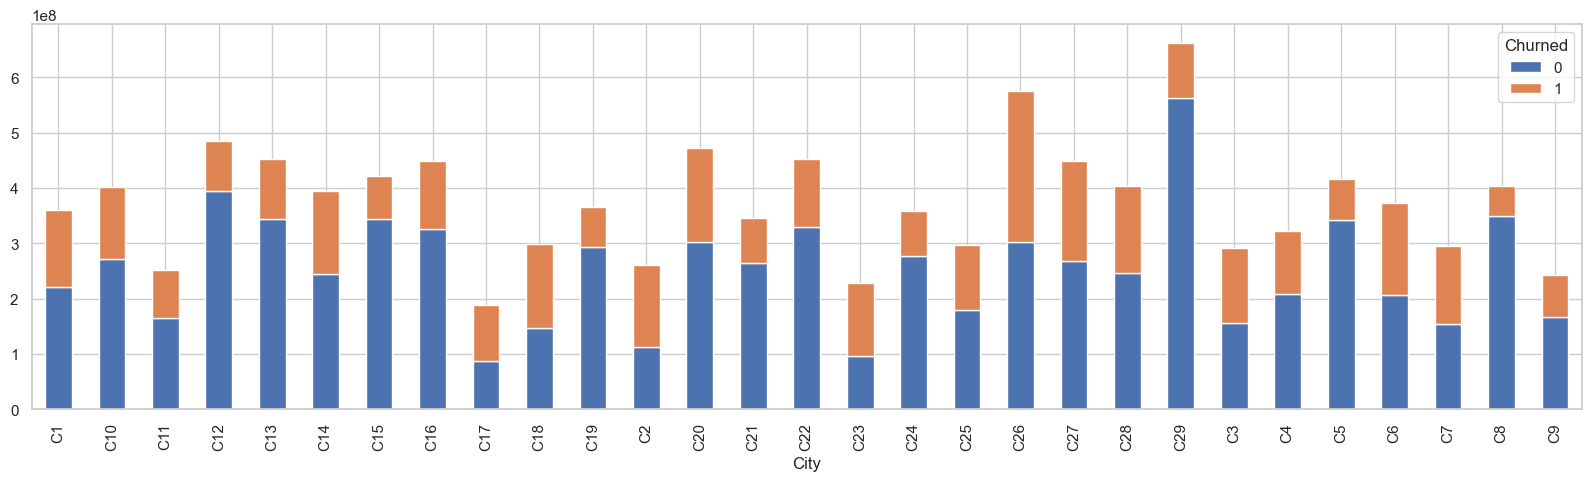

In [30]:
pd.pivot_table(merged_df, index="City", columns="Churned", values="Total_Business_Value", aggfunc="sum").plot(kind="bar", stacked=True, figsize=(20, 5));

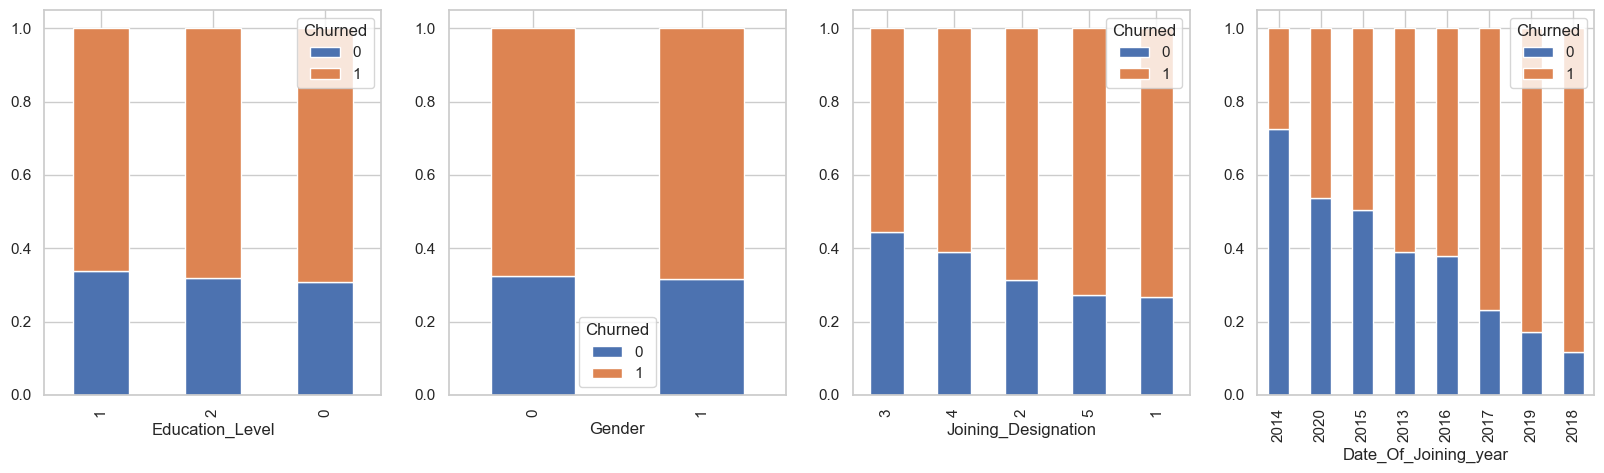

In [71]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

pd.crosstab(merged_df["Education_Level"], merged_df["Churned"],  normalize="index").sort_values(1).plot(kind="bar", stacked=True, ax=ax[0]);
pd.crosstab(merged_df["Gender"], merged_df["Churned"],  normalize="index").sort_values(1).plot(kind="bar", stacked=True, ax=ax[1]);
pd.crosstab(merged_df["Joining_Designation"], merged_df["Churned"],  normalize="index").sort_values(1).plot(kind="bar", stacked=True, ax=ax[2]);
pd.crosstab(merged_df["Date_Of_Joining_year"], merged_df["Churned"],  normalize="index").sort_values(1).plot(kind="bar", stacked=True, ax=ax[3]);



<b style='padding: 2px 8px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- We can see that Gender and Education level donot have significant effect on Churn
- From above plot we can see that Joining designation and Joining year have significant effect on churn

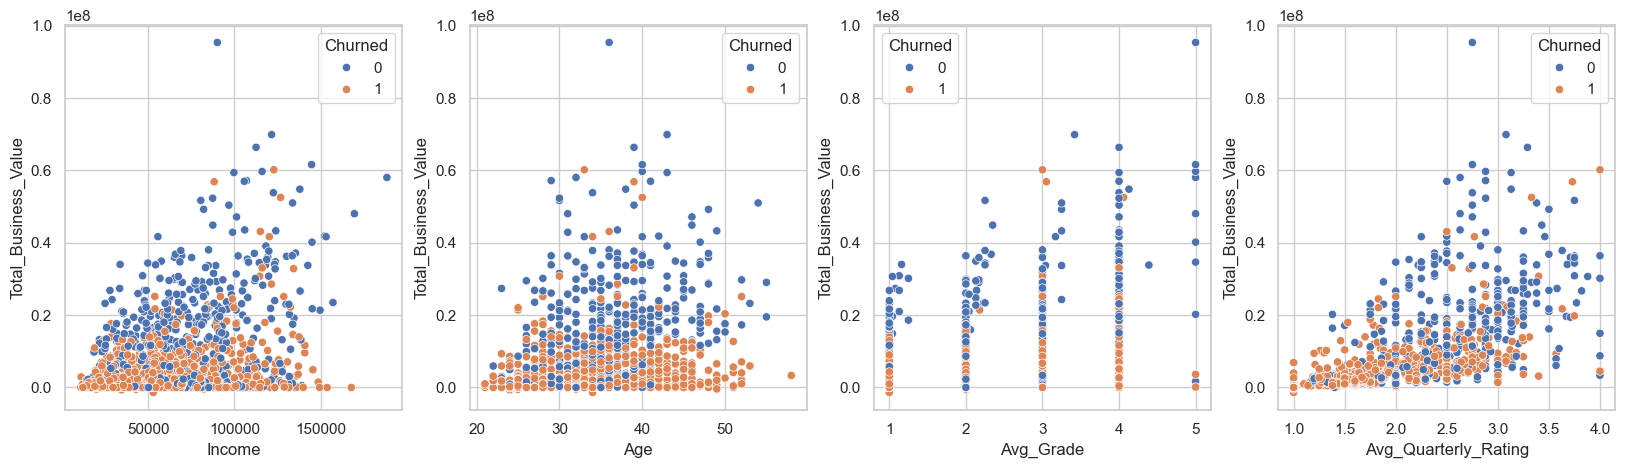

In [73]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))


sns.scatterplot(data=merged_df, x="Income", y="Total_Business_Value", hue="Churned", ax=ax[0]);
sns.scatterplot(data=merged_df, x="Age", y="Total_Business_Value", hue="Churned", ax=ax[1]);
sns.scatterplot(data=merged_df, x="Avg_Grade", y="Total_Business_Value", hue="Churned", ax=ax[2]);
sns.scatterplot(data=merged_df, x="Avg_Quarterly_Rating", y="Total_Business_Value", hue="Churned", ax=ax[3]);

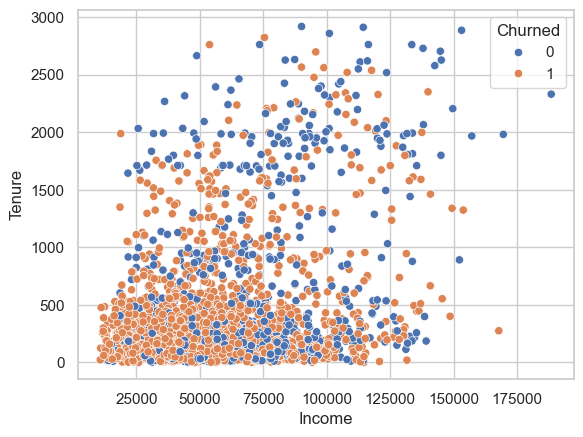

In [6]:
sns.scatterplot(data=merged_df, x="Income", y="Tenure", hue="Churned");

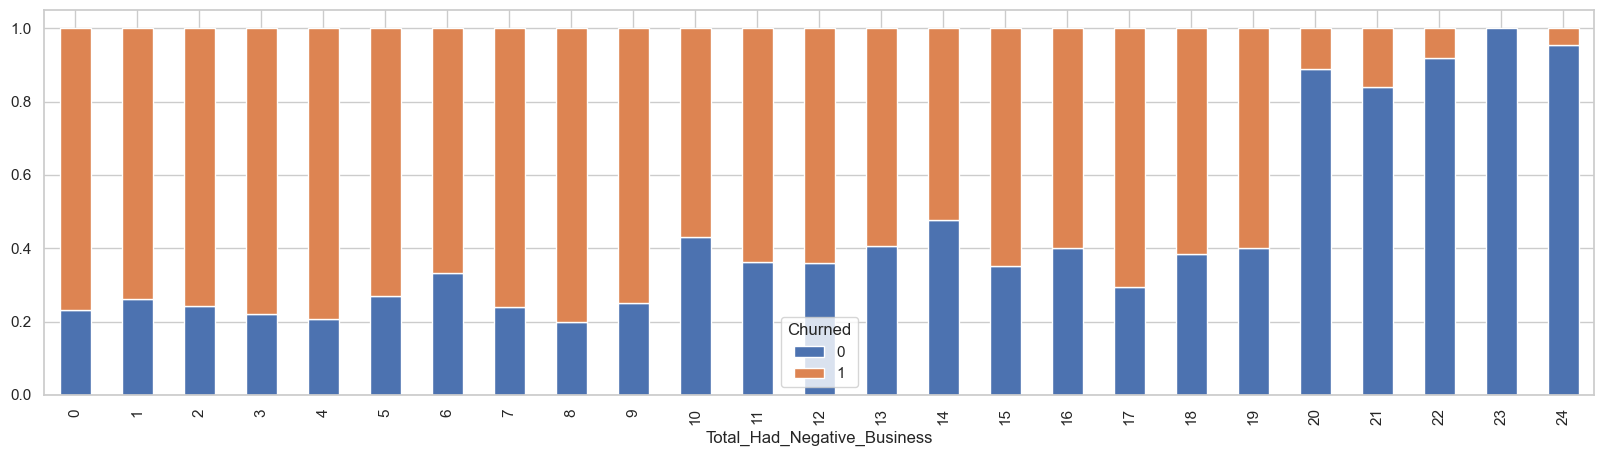

In [13]:
# sns.histplot(data=merged_df, x="Total_Had_Negative_Business", hue="Churned", kde=True);
pd.crosstab(merged_df["Total_Had_Negative_Business"], merged_df["Churned"],  normalize="index").plot(kind="bar", stacked=True, figsize=(20, 5));


In [14]:
merged_df["Avg_Grade"].value_counts()

Avg_Grade
2.00    844
1.00    741
3.00    602
4.00    129
5.00     21
3.25      5
2.25      5
2.17      4
2.13      4
1.13      3
2.04      3
1.04      3
1.25      2
2.33      1
3.04      1
1.08      1
2.06      1
4.06      1
1.16      1
3.17      1
4.13      1
2.14      1
2.23      1
3.05      1
2.18      1
4.39      1
3.42      1
2.35      1
Name: count, dtype: int64

In [ ]:
sns.scatterplot(data=merged_df, x="Total_Had_Negative_Business", y="Total_Business_Value", hue="Churned");

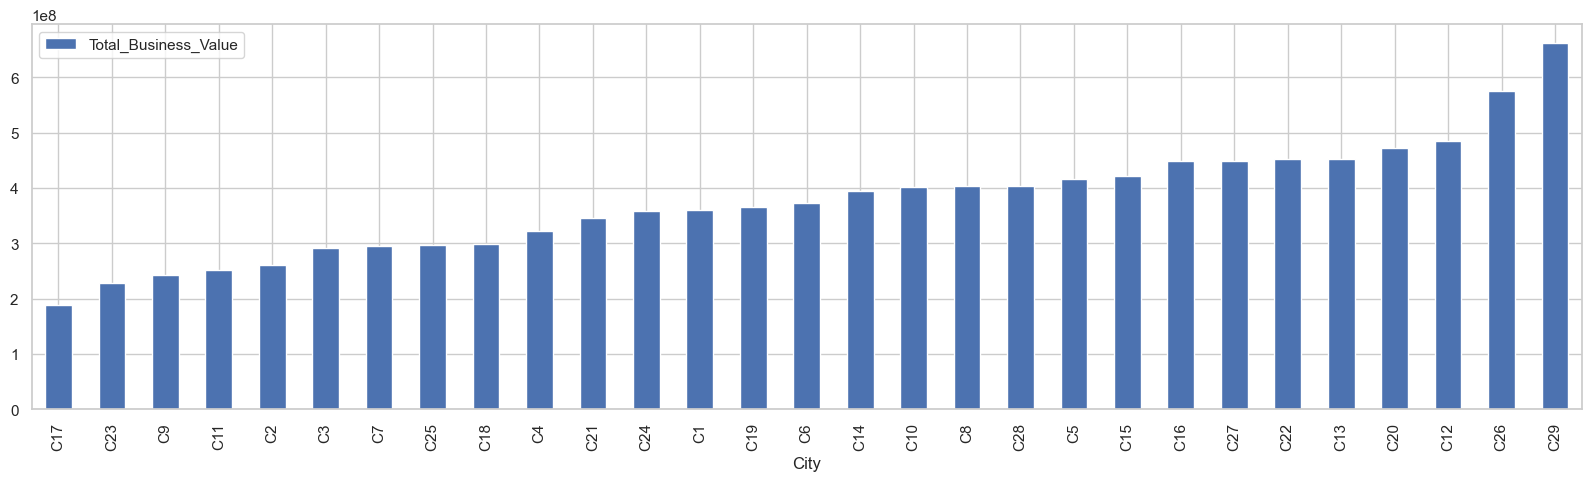

In [74]:
merged_df.groupby("City").agg({"Total_Business_Value": "sum"}).sort_values("Total_Business_Value").plot(kind="bar", figsize=(20, 5));

<b style='padding: 2px 8px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>
- From above plot we can see that C29 city has highest revenue

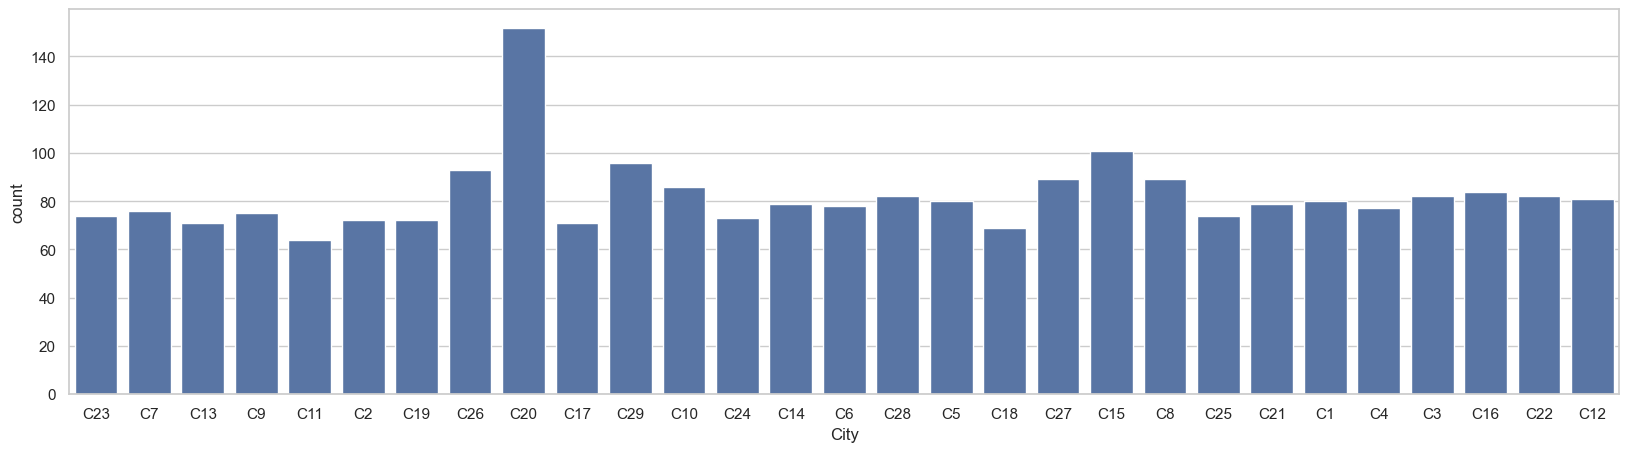

In [80]:
plt.figure(figsize=(20, 5))
sns.countplot(data=merged_df, x="City");

In [75]:
merged_df_corr = merged_df.select_dtypes(include=[np.number]).drop("Driver_ID", axis=1).corr()

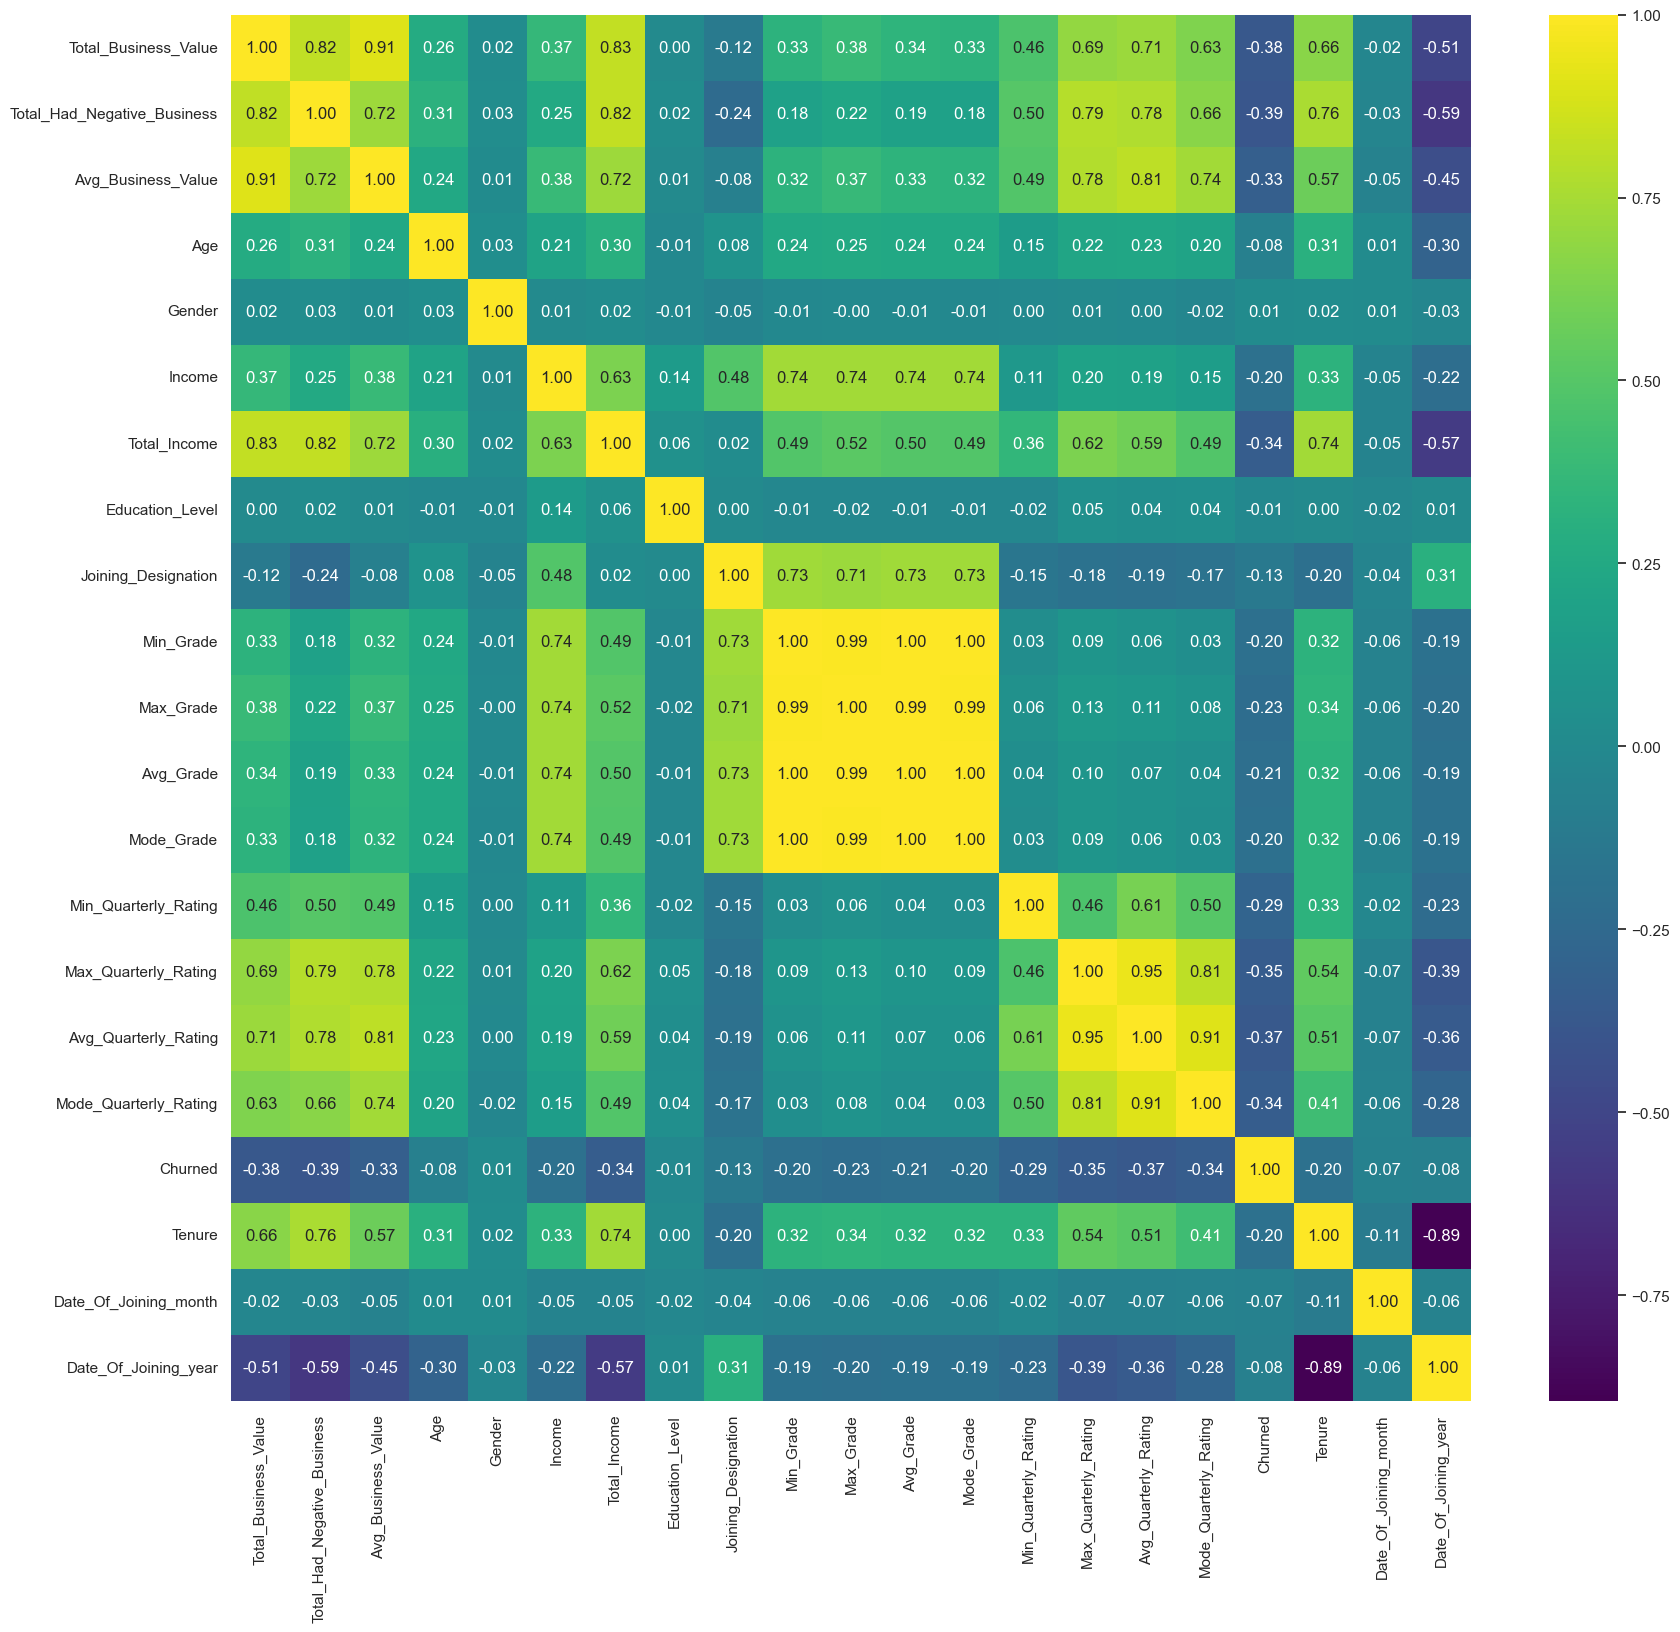

In [76]:
plt.figure(figsize=(20, 18))
sns.heatmap(merged_df_corr, annot=True, cmap="viridis", fmt=".2f");

In [60]:
merged_df.head()

,Driver_ID,Date_Of_Joining,Total_Business_Value,Total_Had_Negative_Business,Avg_Business_Value,Last_Reporting_Month,Age,Gender,Income,Total_Income,...,Max_Grade,Avg_Grade,Mode_Grade,Min_Quarterly_Rating,Max_Quarterly_Rating,Avg_Quarterly_Rating,Mode_Quarterly_Rating,Last_Working_Date,Churned,Tenure
0,1,2018-12-24,1715580,1,571860,2019-03-01,28,0,57387,172161,...,1,1.0,1,2,2,2.0,2,2019-11-03,1,314
1,2,2020-06-11,0,0,0,2020-12-01,31,0,67016,134032,...,2,2.0,2,1,1,1.0,1,None,0,203
2,4,2019-07-12,350000,1,70000,2020-04-01,43,0,65603,328015,...,2,2.0,2,1,1,1.0,1,2020-04-27,1,290
3,5,2019-09-01,120360,1,40120,2019-03-01,29,0,46368,139104,...,1,1.0,1,1,1,1.0,1,2019-07-03,1,60
4,6,2020-07-31,1265000,1,253000,2020-12-01,31,1,78728,393640,...,3,3.0,3,1,2,1.6,2,None,0,153


# Model Building

In [5]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, RandomForestClassificationModel, GBTClassificationModel
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel, TrainValidationSplit, TrainValidationSplitModel
import mlflow
import mlflow.spark
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, roc_curve, roc_auc_score, auc, f1_score, accuracy_score, precision_score, recall_score
from xgboost.spark import SparkXGBClassifier, SparkXGBClassifierModel

from synapse.ml.lightgbm import LightGBMClassifier, LightGBMClassificationModel
from synapse.ml.train import ComputeModelStatistics

In [5]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("ola_driver_churn")

mlflow.pyspark.ml.autolog(
   log_models=False,
   log_input_examples=False,
   exclusive=False,
   silent=True,
   disable=True
);

In [34]:
def print_metrics(y_true, y_pred, y_prob):
    print(classification_report(y_true, y_pred))
    print("Accuracy: ", accuracy_score(y_true, y_pred))
    print("F1 Score: ", f1_score(y_true, y_pred))
    print("AUC: ", roc_auc_score(y_true, y_prob))

def plot_confusion_matrix(y_true, y_pred, normalize='true'):
    cm = confusion_matrix(y_true, y_pred, normalize=normalize, labels=[0, 1])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, cmap="viridis", xticklabels=[0, 1], yticklabels=[0, 1]);
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual');

palette = sns.color_palette("deep", 8)  # You can choose other palettes like "deep", "muted", "bright", etc.

def plot_roc_curve(y_true, y_prob, label="Model", color='orange', show_random=True):
    fpr, tpr, threshold = roc_curve(y_true, y_prob, pos_label=1)

    if show_random:
        random_probs = [0 for i in range(len(y_true))]
        p_fpr, p_tpr, _ = roc_curve(y_true, random_probs, pos_label=1)
        plt.plot(p_fpr, p_tpr, linestyle='--', color='blue', label='Random Model')
    plt.plot(fpr, tpr, linestyle='--', color=color, label=label)
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()


def plot_precision_recall_curve(y_true, y_prob, label="Model", color='orange'):
    precision, recall, thr = precision_recall_curve(y_true,y_prob)
    plt.plot(recall, precision, color=color, label=label)

    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))

    plt.xlabel('Recall Value')
    plt.ylabel('Precision Value')
    plt.title("PR Curve")
    plt.legend()
    
def plot_precision_recall_threshold_curve(y_true, y_prob):
    precision, recall, thr = precision_recall_curve(y_true,y_prob)
    threshold_boundary = thr.shape[0]

    plt.plot(thr, precision[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thr, recall[0:threshold_boundary], label='recall')

    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))

    plt.xlabel('Threshold Value')
    plt.ylabel('Precision Recall Value')
    plt.legend()
    plt.title("PR - Threshold Curve")
    plt.show();

from pyspark.ml import Model
from pyspark.sql import DataFrame
from typing import Callable, Tuple


def get_feature_importance(
    model: Model, 
    spark_df: DataFrame, 
    model_type: str = "pyspark"
) -> Tuple[Callable[[], None], pd.DataFrame]:
    """
    Generates a feature importance DataFrame and a lazy plot function for a given model and DataFrame.

    Parameters:
    model : pyspark.ml.Model
        The trained model from which to extract feature importances.
    spark_df : pyspark.sql.DataFrame
        The DataFrame containing the features used in the model. The DataFrame
        should have a schema with metadata that includes feature names and indices.
    model_type : str
        The type of the model ("pyspark", "lightgbm", or "xgboost").

    Returns:
    tuple
        A tuple containing:
        - plot (function): A function that, when called, generates and displays the feature importance plot.
        - pandas_df (pd.DataFrame): A Pandas DataFrame containing the feature names and their corresponding importance scores, sorted in descending order of importance.
    """

    feature_names = sorted(
        spark_df.schema["features"].metadata["ml_attr"]["attrs"]["binary"] + 
        spark_df.schema["features"].metadata["ml_attr"]["attrs"]["numeric"], 
        key=lambda x: x["idx"]
    )
    
    if model_type == "pyspark":
        importances = model.featureImportances
    elif model_type == "lightgbm":
        importances = model.getFeatureImportances()
    elif model_type == "xgboost":
        feature_imp_obj = [{"idx": int(k[1:]), "Importance": v} for k, v in model.get_feature_importances().items()]
        pandas_df = pd.DataFrame(feature_names).merge(
            pd.DataFrame(feature_imp_obj), on="idx", how="left"
        ).rename(columns={'name': "Feature"}).fillna(0).sort_values("Importance", ascending=False).drop("idx", axis=1)
        
        def plot() -> None:
            pandas_df.plot(kind="bar", x="Feature", y="Importance", figsize=(20, 5))

        return plot, pandas_df
    else:
        raise ValueError(f"Unsupported model type: {model_type}")

    # Common case for pyspark and lightgbm
    feature_importance_mapping = {
        x["name"]: y for x, y in zip(feature_names, importances)
    }
    pandas_df = pd.DataFrame(
        feature_importance_mapping.items(), 
        columns=["Feature", "Importance"]
    ).sort_values("Importance", ascending=False)

    def plot() -> None:
        pandas_df.plot(kind="bar", x="Feature", y="Importance", figsize=(20, 5))

    return plot, pandas_df


def spark_prediction_to_numpy(predictions: DataFrame):
    """
    Converts Spark DataFrame predictions to NumPy arrays.

    Parameters:
    predictions : pyspark.sql.DataFrame
        The Spark DataFrame containing the columns 'prediction', 'probability', and 'Churned'.

    Returns:
    tuple
        A tuple containing:
        - y_true (np.ndarray): The true labels.
        - y_pred (np.ndarray): The predicted labels.
        - y_prob (np.ndarray): The predicted probabilities.
    """
    data = predictions.select("prediction", "probability", "Churned").collect()
    
    y_true = np.array([row['Churned'] for row in data])
    y_pred = np.array([row['prediction'] for row in data])
    y_prob = np.array([row['probability'][1] for row in data])
    
    return y_true, y_pred, y_prob



def get_all_model_params(model: CrossValidatorModel, metric="f1"):
    params = [{p.name: v for p, v in m.items()} for m in model.getEstimatorParamMaps()]

    _ = pd.DataFrame.from_dict([
        {model.getEvaluator().getMetricName(): _metric, **ps} 
        for ps, _metric in zip(params, model.avgMetrics)
    ])
    return _.sort_values(metric, ascending=False)

def get_all_model_params_tvs(model: TrainValidationSplitModel, metric="f1"):
    params = [{p.name: v for p, v in m.items()} for m in model.getEstimatorParamMaps()]

    _ = pd.DataFrame.from_dict([
        {model.getEvaluator().getMetricName(): _metric, **ps} 
        for ps, _metric in zip(params, model.validationMetrics)
    ])
    return _.sort_values(metric, ascending=False)
    

def fit_model(model, paramGrid, data, use_train_validation_split=False):
    evaluator = MulticlassClassificationEvaluator(labelCol="Churned", predictionCol="prediction", metricName="f1", weightCol='classWeightCol')

    if use_train_validation_split:
        _model = TrainValidationSplit(estimator=model,
                            estimatorParamMaps=paramGrid,
                            evaluator=evaluator,
                            parallelism=16, 
                            collectSubModels=True,
                            trainRatio = 0.8,
                            seed=42)
    else:
        _model = CrossValidator(estimator=model,
                            estimatorParamMaps=paramGrid,
                            evaluator=evaluator,
                            numFolds=3,
                            parallelism=16, 
                            collectSubModels=True,
                            seed=42)
    cvModel = _model.fit(data)
    return cvModel, evaluator

# def get_best_threshold(y_true, y_prob):
#     fpr, tpr, thresholds = roc_curve(y_true, y_prob, pos_label=1)
#     gmeans = np.sqrt(tpr * (1-fpr))
#     ix = np.argmax(gmeans)
#     return thresholds[ix]

def get_best_threshold(y_true, y_prob):
    thresholds = np.arange(0.0, 1.0, 0.01)

    precisions = []
    recalls = []
    f1s = []

    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        precisions.append(precision_score(y_true, y_pred))
        recalls.append(recall_score(y_true, y_pred))
        f1s.append(f1_score(y_true, y_pred))
        
    best_threshold = thresholds[np.argmax(f1s)]

    print(f'Best threshold: {best_threshold}')
    print(f'Precision at best threshold: {precisions[np.argmax(f1s)]}')
    print(f'Recall at best threshold: {recalls[np.argmax(f1s)]}')
    print(f'F1 score at best threshold: {f1s[np.argmax(f1s)]}')
    return best_threshold

## Preprocessing

In [7]:
model_df = spark.read.parquet("ola_driver_merged.parquet")
model_df.cache();

In [9]:
model_df.limit(3).toPandas().T

,0,1,2
Driver_ID,1,2,4
Date_Of_Joining,2018-12-24,2020-06-11,2019-07-12
Total_Business_Value,1715580,0,350000
Total_Had_Negative_Business,1,0,1
Avg_Business_Value,571860,0,70000
Last_Reporting_Month,2019-03-01,2020-12-01,2020-04-01
Age,28,31,43
Gender,0,0,0
Income,57387,67016,65603
Total_Income,172161,134032,328015


**Categorical and OneHot Encoding**

In [8]:
categorical_columns = ["City"]
indexers = [StringIndexer(inputCol=column, outputCol=column + "Index") for column in categorical_columns]

for indexer in indexers:
    model_df = indexer.fit(model_df).transform(model_df)
    encoder = OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol=indexer.getInputCol() + "_Vec")
    model_df = encoder.fit(model_df).transform(model_df)

feature_columns = ['Avg_Business_Value', 'Age', 'Gender', 
                   'Income', 'Total_Income', 'Education_Level', 'City_Vec', 'Joining_Designation', 
                   'Min_Grade', 'Max_Grade', 'Avg_Grade', 'Mode_Grade', 'Min_Quarterly_Rating', 'Max_Quarterly_Rating', 
                   'Avg_Quarterly_Rating', 'Mode_Quarterly_Rating', 'Tenure', 'Date_Of_Joining_month', 'Date_Of_Joining_year',"Is_Valuable_Driver",'Total_Business_Value', 'Total_Had_Negative_Business' ]

to_drop = ["Driver_ID", "Date_Of_Joining", "Last_Working_Date","Last_Reporting_Month", "CityIndex"]
model_df = model_df.drop(*to_drop)

**Vectorization**

In [9]:
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
model_df = assembler.transform(model_df)
class_weights = model_df.groupBy("Churned").count().collect()
total_count = model_df.count()
weights = {row['Churned']: total_count / row['count'] for row in class_weights}
model_df = model_df.withColumn("classWeightCol", sf.when(model_df["Churned"] == 1, weights[1]).otherwise(weights[0]))

**Train Test Validation Split**

In [10]:
(trainingData, testData) = model_df.randomSplit([0.8, 0.2], seed=42)
trainingData_v2, validationData = trainingData.randomSplit([0.8, 0.2], seed=42)

In [11]:
trainingData.write.parquet("ola_driver_training.parquet", mode='overwrite')
testData.write.parquet("ola_driver_test.parquet", mode='overwrite')
validationData.write.parquet("ola_driver_validation.parquet", mode='overwrite')
trainingData_v2.write.parquet("ola_driver_training_v2.parquet", mode='overwrite')

In [13]:
# load the data
trainingData = spark.read.parquet("ola_driver_training.parquet")
testData = spark.read.parquet("ola_driver_test.parquet")
validationData = spark.read.parquet("ola_driver_validation.parquet")
trainingData_v2 = spark.read.parquet("ola_driver_training_v2.parquet")
# cache all the data
trainingData.cache()
testData.cache()
validationData.cache()
trainingData_v2.cache()


DataFrame[Total_Business_Value: bigint, Total_Had_Negative_Business: bigint, Avg_Business_Value: int, Age: int, Gender: int, Income: int, Total_Income: bigint, Education_Level: int, City: string, Joining_Designation: int, Min_Grade: int, Max_Grade: int, Avg_Grade: double, Mode_Grade: int, Min_Quarterly_Rating: int, Max_Quarterly_Rating: int, Avg_Quarterly_Rating: double, Mode_Quarterly_Rating: int, Churned: int, Tenure: int, Date_Of_Joining_month: int, Date_Of_Joining_year: int, Is_Valuable_Driver: int, City_Vec: vector, features: vector, classWeightCol: double]

## Random Forest

In [15]:
rf = RandomForestClassifier(labelCol="Churned", featuresCol="features", weightCol="classWeightCol", seed=42)
paramGrid = ParamGridBuilder().addGrid(rf.numTrees, [10, 20, 30, 50, 100, 200]).addGrid(rf.maxDepth, [5, 10, 15, 20]).build()


with mlflow.start_run(run_name="Random Forest" ):
    rf_cv_model, rf_evaluator = fit_model(rf, paramGrid, trainingData)
    mlflow.log_params({
        "best_numTrees": rf_cv_model.bestModel.getNumTrees,
        "best_maxDepth": rf_cv_model.bestModel.getMaxDepth()
    })
    test_predictions = rf_cv_model.bestModel.transform(testData)

    mlflow.log_metrics({
        "best_f1": rf_evaluator.evaluate(test_predictions),
        "best_accuracy": rf_evaluator.setMetricName("accuracy").evaluate(test_predictions),
        "best_precision": rf_evaluator.setMetricName("weightedPrecision").evaluate(test_predictions),
        "best_recall": rf_evaluator.setMetricName("weightedRecall").evaluate(test_predictions)
    })

In [46]:
best_rf = rf_cv_model.bestModel
print("NumTrees: ", best_rf.getNumTrees, "MaxDepth: ", best_rf.getMaxDepth())
best_rf.save("./model/rf_model")

NumTrees:  50 MaxDepth:  20


In [16]:
best_rf = RandomForestClassificationModel.load("./model/rf_model")
print("NumTrees: ", best_rf.getNumTrees, "MaxDepth: ", best_rf.getMaxDepth());

NumTrees:  50 MaxDepth:  20


In [32]:
test_predictions = best_rf.transform(testData)

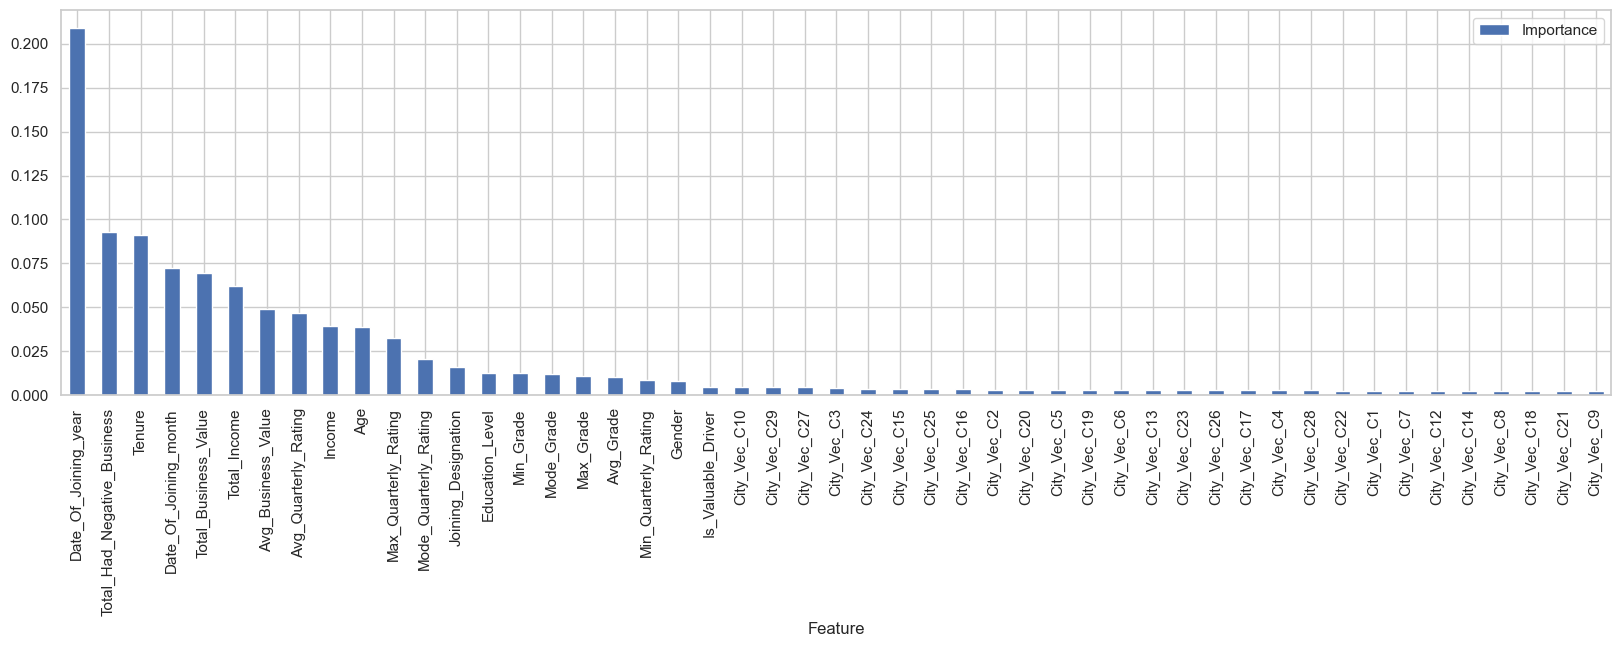

In [18]:
plot_func, _= get_feature_importance(best_rf, model_df)
plot_func();

In [34]:
y_true, y_pred, y_prob = spark_prediction_to_numpy(test_predictions);

24/08/18 12:49:12 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


In [35]:
print_metrics(y_true, y_pred, y_prob)

              precision    recall  f1-score   support

           0       0.82      0.76      0.79       154
           1       0.86      0.90      0.88       263

    accuracy                           0.85       417
   macro avg       0.84      0.83      0.84       417
weighted avg       0.85      0.85      0.85       417

Accuracy:  0.8489208633093526
F1 Score:  0.88268156424581
AUC:  0.9200162954915806


In [22]:
best_threshold= get_best_threshold(y_true, y_prob)

Best threshold: 0.5700000000000001
Precision at best threshold: 0.9019607843137255
Recall at best threshold: 0.8745247148288974
F1 score at best threshold: 0.888030888030888


**PR vs Threshold Curve**

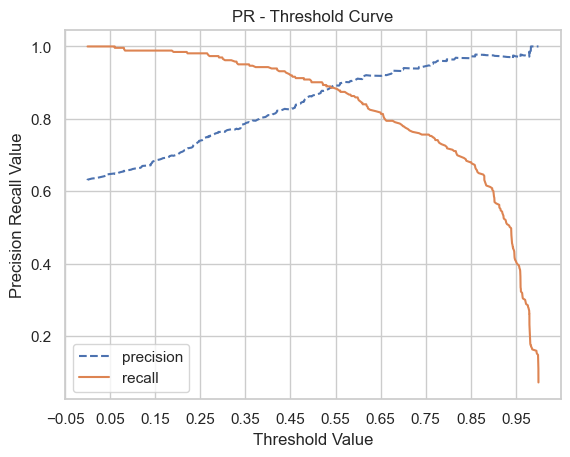

In [36]:
plot_precision_recall_threshold_curve(y_true, y_prob)

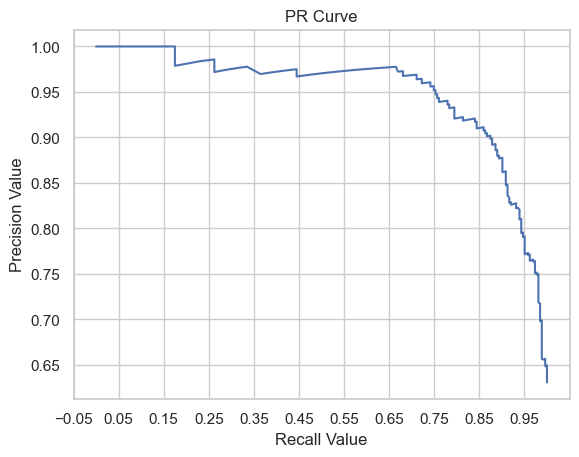

In [37]:
plot_precision_recall_curve(y_true, y_prob)

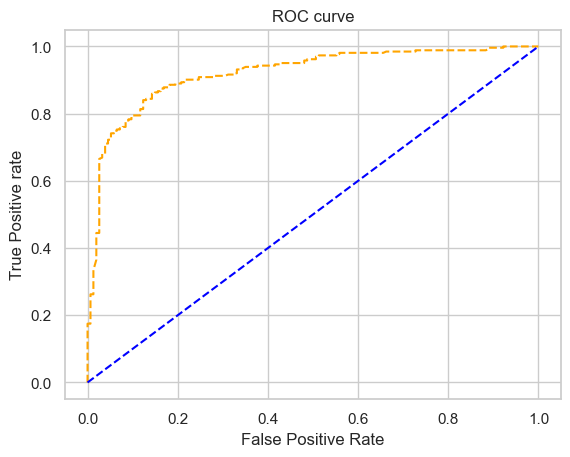

In [38]:
plot_roc_curve(y_true, y_prob)

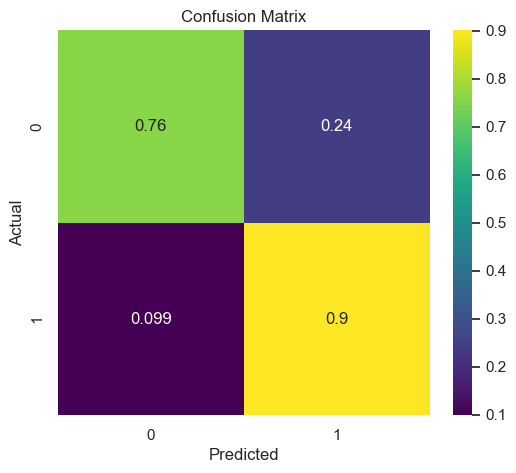

In [39]:
plot_confusion_matrix(y_true, y_pred)

## Gradient Boosting Classifier

In [16]:
gbt = GBTClassifier(labelCol="Churned", featuresCol="features", weightCol="classWeightCol", seed=42, subsamplingRate=0.8)

In [17]:
paramGrid = ParamGridBuilder()

maxDepth_values = np.random.choice(range(3, 10), size=4, replace=False)
# maxBins_values = np.random.choice(range(32, 257), size=5, replace=False)
stepSize_values =[0.1, 0.2]
maxIter_values = [30, 50, 100, 150]
# subsamplingRate_values = [0.8,1.0]

paramGrid = paramGrid.addGrid(gbt.maxDepth, maxDepth_values) \
                    .addGrid(gbt.maxIter, maxIter_values) \
                    .addGrid(gbt.stepSize, stepSize_values) \
                    .build()



In [18]:
%%time
with mlflow.start_run(run_name="Gradient Boosting" ):
    gbt_cv_model, gbt_evaluator = fit_model(gbt, paramGrid, trainingData, use_train_validation_split=True)

    mlflow.log_params({
        "best_maxDepth": gbt_cv_model.bestModel.getMaxDepth(),
        "best_stepSize": gbt_cv_model.bestModel.getStepSize(),
        "best_maxIter": gbt_cv_model.bestModel.getMaxIter(),
    })
    test_predictions = gbt_cv_model.bestModel.transform(testData)

    mlflow.log_metrics({
        "best_f1": gbt_evaluator.evaluate(test_predictions),
        "best_accuracy": gbt_evaluator.setMetricName("accuracy").evaluate(test_predictions),
        "best_precision": gbt_evaluator.setMetricName("weightedPrecision").evaluate(test_predictions),
        "best_recall": gbt_evaluator.setMetricName("weightedRecall").evaluate(test_predictions)
    })

CPU times: user 2.5 s, sys: 991 ms, total: 3.49 s
Wall time: 8min 54s


In [26]:
gbt_best = gbt_cv_model.bestModel
# gbt_best.getMaxDepth(), gbt_best.getMaxIter(), gbt_best.getStepSize()

print("MaxDepth:", gbt_best.getMaxDepth(), ", MaxIter:", gbt_best.getMaxIter(), ", StepSize:", gbt_best.getStepSize())

MaxDepth: 6 , MaxIter: 100 , StepSize: 0.1


In [20]:
gbt_best.save("./model/gbt_model")

In [40]:
gbt_best = GBTClassificationModel.load("./model/gbt_model")
print("MaxDepth:", gbt_best.getMaxDepth(), ", MaxIter:", gbt_best.getMaxIter(), ", StepSize:", gbt_best.getStepSize())

MaxDepth: 6 , MaxIter: 100 , StepSize: 0.1


In [41]:
y_true, y_pred, y_prob = spark_prediction_to_numpy(gbt_best.transform(testData))

24/08/18 13:20:35 WARN DAGScheduler: Broadcasting large task binary with size 1148.1 KiB
24/08/18 13:20:36 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


In [42]:
print_metrics(y_true, y_pred, y_prob)

              precision    recall  f1-score   support

           0       0.88      0.90      0.89       154
           1       0.94      0.93      0.93       263

    accuracy                           0.92       417
   macro avg       0.91      0.92      0.91       417
weighted avg       0.92      0.92      0.92       417

Accuracy:  0.9184652278177458
F1 Score:  0.9348659003831418
AUC:  0.9637548763024048


In [43]:
best_threshold= get_best_threshold(y_true, y_prob)

Best threshold: 0.41000000000000003
Precision at best threshold: 0.9389312977099237
Recall at best threshold: 0.935361216730038
F1 score at best threshold: 0.9371428571428572


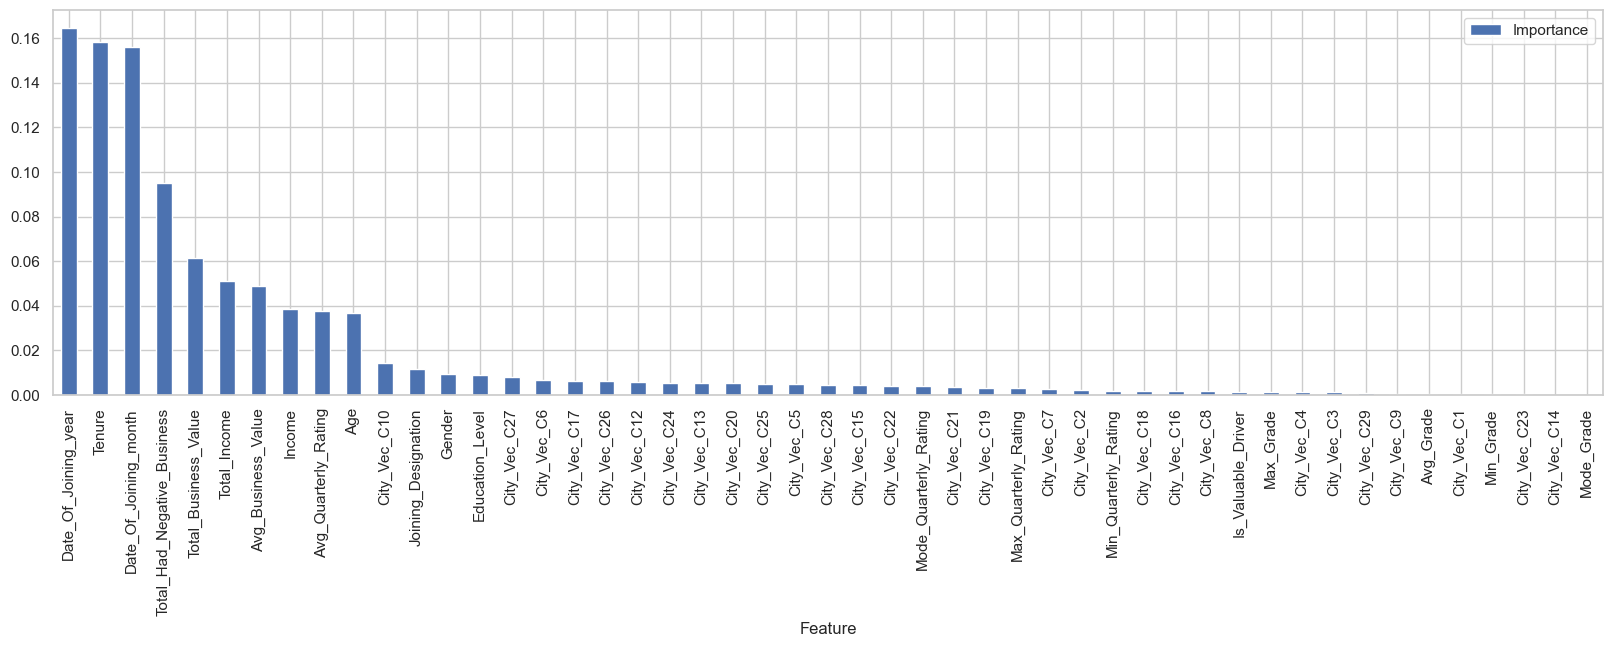

In [23]:
plotfn, _=get_feature_importance(gbt_best, model_df)
plotfn()

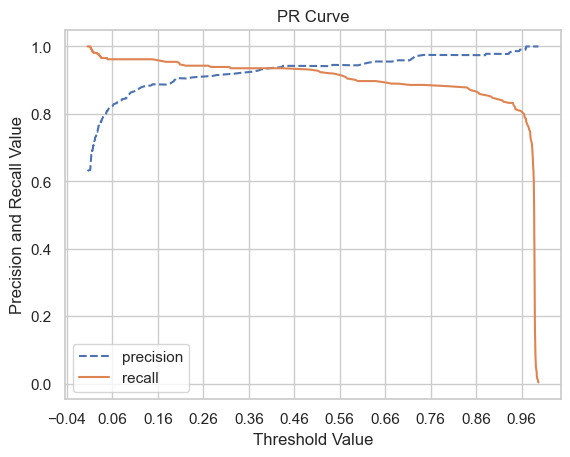

In [27]:
plot_precision_recall_curve(y_true, y_prob)

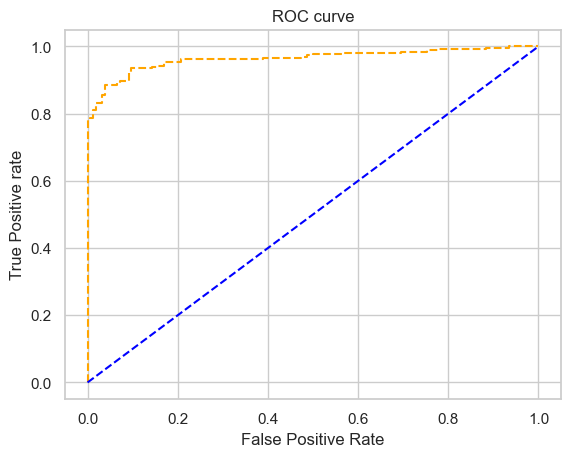

In [28]:
plot_roc_curve(y_true, y_prob)

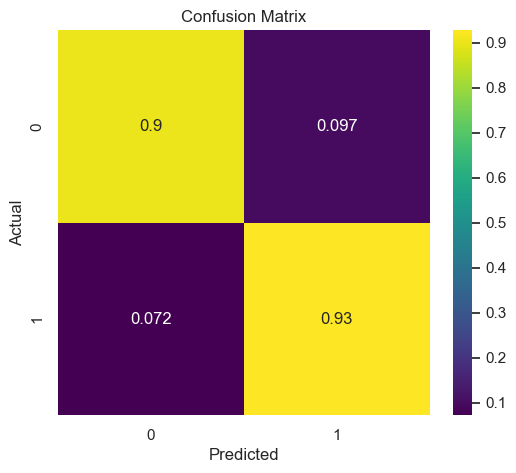

In [29]:
plot_confusion_matrix(y_true, y_pred)

## XGBoost

In [12]:
xgb = SparkXGBClassifier(label_col="Churned", features_col="features", weight_col="classWeightCol", seed=42,  verbose=False)
# xgb_feat = SparkXGBClassifier(label_col="Churned", features_col="features", weight_col="classWeightCol", seed=42, max_depth=5, n_estimators=150, learning_rate=0.1, subsample=0.8)

In [13]:
paramGrid = ParamGridBuilder()

maxDepth_values = [3, 5, 7, 10]
# maxBins_values = np.random.choice(range(32, 257), size=5, replace=False)
eta =[0.1, 0.2, 0.3]
num_boosting_rounds_values = [50, 100, 150, 200]
subsample_values = [0.8, 1.0]

paramGrid = paramGrid.addGrid(xgb.max_depth, maxDepth_values) \
                    .addGrid(xgb.learning_rate, eta) \
                    .addGrid(xgb.n_estimators, num_boosting_rounds_values) \
                    .addGrid(xgb.subsample, subsample_values) \
                    .build()

In [14]:
with mlflow.start_run(run_name="XGBoost" ):
    xgb_cv_model, xgb_evaluator= fit_model(xgb, paramGrid, trainingData);

    params = {param.name: xgb_cv_model.bestModel.getOrDefault(param) 
              for param in xgb_cv_model.bestModel.extractParamMap()}

    mlflow.log_params({
        "best_maxDepth": params["max_depth"],
        "best_learningRate": params["learning_rate"],
        "best_nEstimators": params["n_estimators"],
        "best_subsample": params["subsample"]
    })
    test_predictions = xgb_cv_model.bestModel.transform(testData)

    mlflow.log_metrics({
        "best_f1": xgb_evaluator.evaluate(test_predictions),
        "best_accuracy": xgb_evaluator.setMetricName("accuracy").evaluate(test_predictions),
        "best_precision": xgb_evaluator.setMetricName("weightedPrecision").evaluate(test_predictions),
        "best_recall": xgb_evaluator.setMetricName("weightedRecall").evaluate(test_predictions)
    })
clear_output()

In [37]:
xgb_best.save("./model/xgb_model")

In [83]:
xgb_best.explainParam("max_depth"), xgb_best.explainParam("learning_rate"), xgb_best.explainParam("n_estimators"), xgb_best.explainParam("subsample")

('max_depth: Refer to XGBoost doc of xgboost.sklearn.XGBClassifier for this param max_depth (default: None, current: 5)',
 'learning_rate: Refer to XGBoost doc of xgboost.sklearn.XGBClassifier for this param learning_rate (default: None, current: 0.2)',
 'n_estimators: Refer to XGBoost doc of xgboost.sklearn.XGBClassifier for this param n_estimators (default: 100, current: 150)',
 'subsample: Refer to XGBoost doc of xgboost.sklearn.XGBClassifier for this param subsample (default: None, current: 1.0)')

In [45]:
xgb_best = SparkXGBClassifierModel.load("./model/xgb_model")
xgb_best.explainParam("max_depth"), xgb_best.explainParam("learning_rate"), xgb_best.explainParam("n_estimators"), xgb_best.explainParam("subsample")

('max_depth: Refer to XGBoost doc of xgboost.sklearn.XGBClassifier for this param max_depth (default: None, current: 5)',
 'learning_rate: Refer to XGBoost doc of xgboost.sklearn.XGBClassifier for this param learning_rate (default: None, current: 0.2)',
 'n_estimators: Refer to XGBoost doc of xgboost.sklearn.XGBClassifier for this param n_estimators (default: 100, current: 150)',
 'subsample: Refer to XGBoost doc of xgboost.sklearn.XGBClassifier for this param subsample (default: None, current: 1.0)')

In [48]:
test_predictions = xgb_best.transform(testData)

In [49]:
y_true, y_pred, y_prob = spark_prediction_to_numpy(test_predictions)

2024-08-18 13:23:44,618 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


In [50]:
best_threshold= get_best_threshold(y_true, y_prob)

Best threshold: 0.35000000000000003
Precision at best threshold: 0.9571984435797666
Recall at best threshold: 0.935361216730038
F1 score at best threshold: 0.9461538461538461


In [51]:
y_pred = (y_prob >= best_threshold).astype(int)

In [52]:
print_metrics(y_true, y_pred, y_prob)

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       154
           1       0.96      0.94      0.95       263

    accuracy                           0.93       417
   macro avg       0.93      0.93      0.93       417
weighted avg       0.93      0.93      0.93       417

Accuracy:  0.9328537170263789
F1 Score:  0.9461538461538461
AUC:  0.9687422843316379


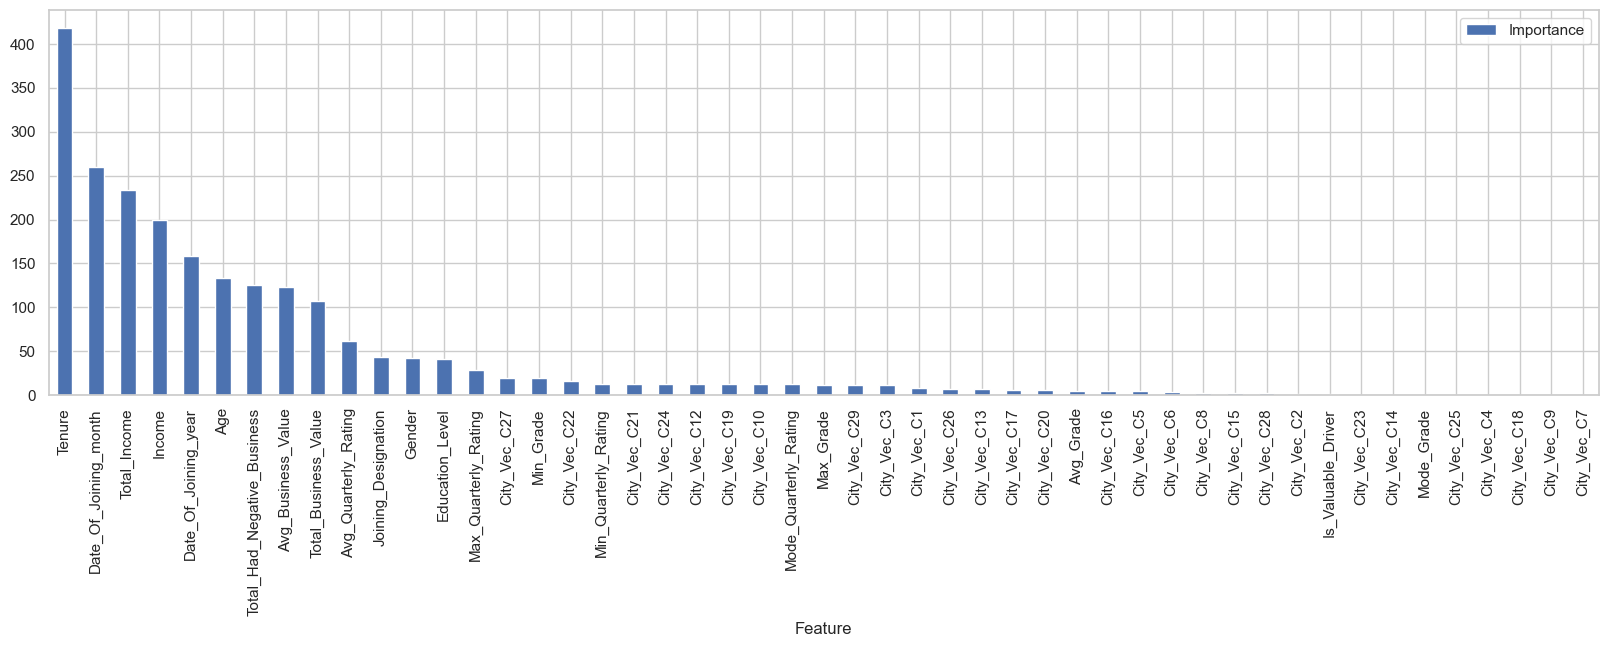

In [70]:
plotfn, _=get_feature_importance_xgboost(xgb_best, model_df)
plotfn()

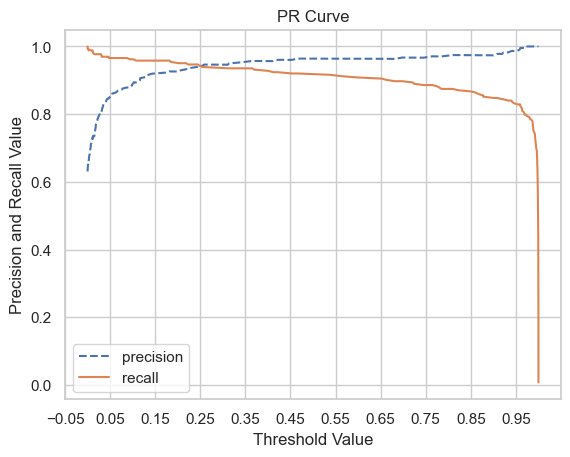

In [71]:
plot_precision_recall_curve(y_true, y_prob)

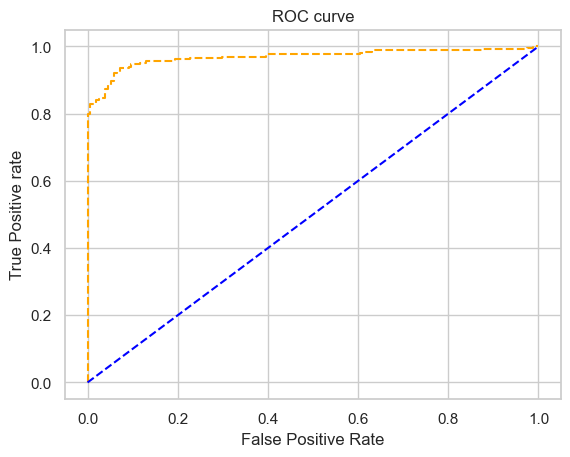

In [72]:
plot_roc_curve(y_true, y_prob)

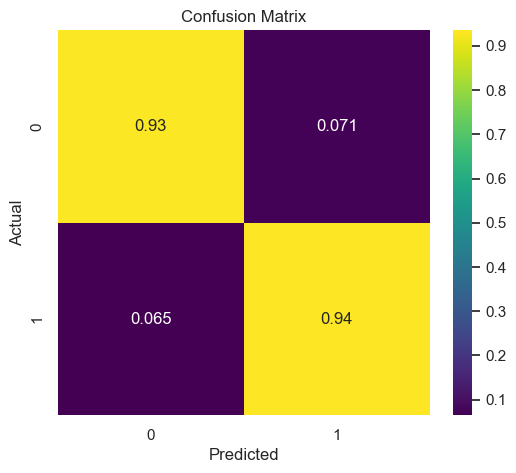

In [53]:
plot_confusion_matrix(y_true, y_pred)

## Light GBM

In [54]:
def train_tree(learningRate, numIterations, baggingFraction, tuning=False):
    with mlflow.start_run(nested=True, run_name="LightGBM_default"):

        lgbm = LightGBMClassifier(labelCol="Churned",
                                    featuresCol="features",
                                    weightCol="classWeightCol",
                                    featuresShapCol="shap_values",
                                    seed=42,
                                  learningRate=learningRate,
                                  numIterations=numIterations,
                                #   maxDepth=maxDepth,
                                  baggingFraction=baggingFraction
                                    )

        if tuning:
            _train = trainingData_v2
            _validation = validationData
        else:
            _train = trainingData
            _validation = testData

        model = lgbm.fit(_train)

        evaluator = MulticlassClassificationEvaluator(
            labelCol="Churned", predictionCol="prediction", metricName="f1", weightCol='classWeightCol')

        predictions = model.transform(_validation)
        f1 = evaluator.evaluate(predictions)
        mlflow.log_params({
            "learningRate": learningRate,
            "numIterations": numIterations,
            # "maxDepth": maxDepth,
            "baggingFraction": baggingFraction
        })
        mlflow.log_metric("f1", f1)
    return model, f1

In [23]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK


def train_with_hyperopt(params):
    """
    An example train method that calls into MLlib.
    This method is passed to hyperopt.fmin().

    :param params: hyperparameters as a dict. Its structure is consistent with how search space is defined. See below.
    :return: dict with fields 'loss' (scalar loss) and 'status' (success/failure status of run)
    """
   
    learningRate=params["learningRate"]
    numIterations=params["numIterations"]
    # maxDepth=params["maxDepth"]
    baggingFraction=params["baggingFraction"]

    model, val_metric = train_tree(
        learningRate=learningRate, numIterations=numIterations, baggingFraction=baggingFraction , tuning=True
    )
    loss = -val_metric

    return {"loss": loss, "status": STATUS_OK}

space = {
    "learningRate": hp.uniform("learningRate", 0.1, 0.3),
    "numIterations": hp.uniformint("numIterations", 50, 200),
    # "maxDepth": hp.uniformint("maxDepth", 3, 10),
    "baggingFraction": hp.uniform("baggingFraction", 0.6, 1.0),
}

algo = tpe.suggest

with mlflow.start_run(run_name="Hyperopt_LGBM" ):
    best_params = fmin(fn=train_with_hyperopt, space=space, algo=algo, max_evals=30)

clear_output()

In [24]:
best_params

{'baggingFraction': 0.8424352182921538,
 'learningRate': 0.1604942075321934,
 'numIterations': 132.0}

In [55]:
final_model, metric = train_tree(**best_params, tuning=False)

[LightGBM] [Info] Saving data reference to binary buffer


[LightGBM] [Info] Loaded reference dataset: 49 features, 1964 num_data


In [26]:
metric

0.9352427604847803

In [56]:
final_model.write().overwrite().save("./model/lgbm_model")

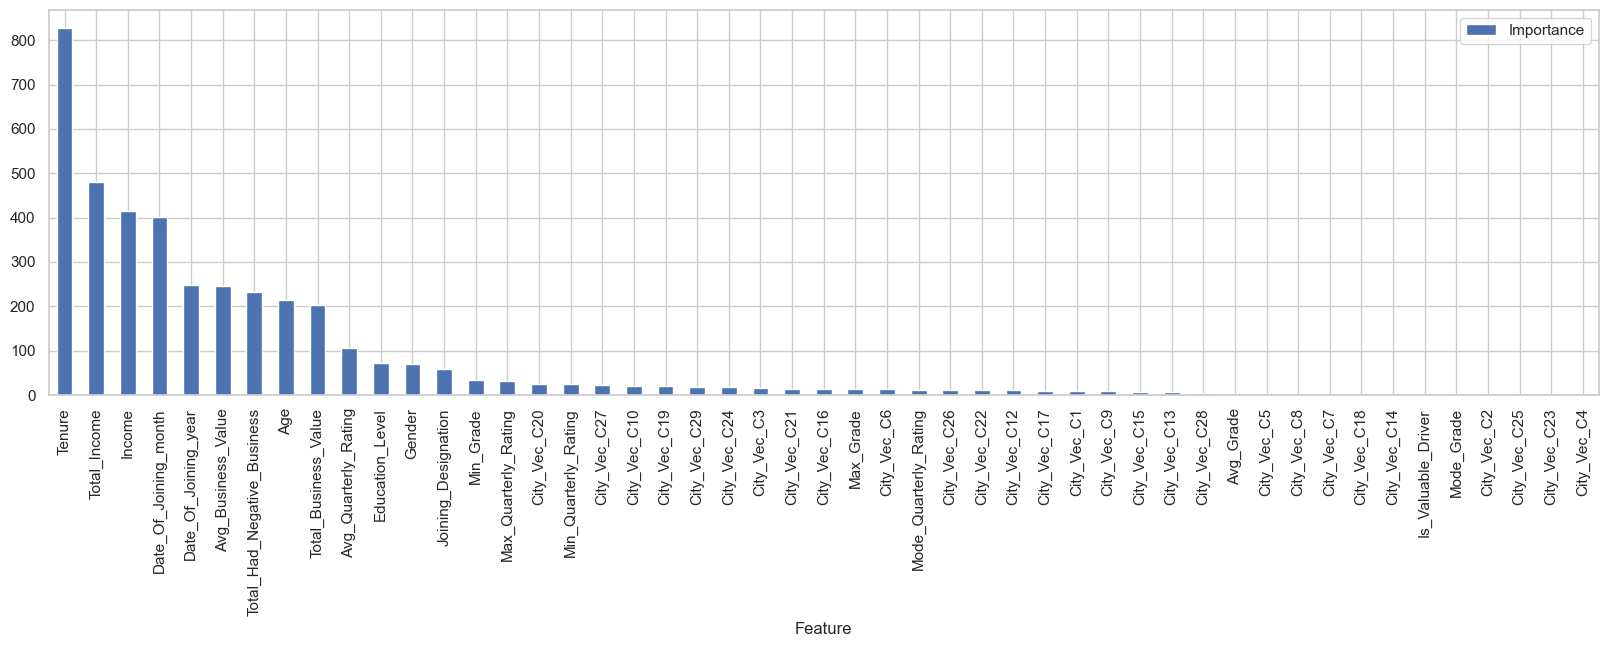

In [48]:
plot_func, _=get_feature_importance(final_model, model_df, model_type="lightgbm")
plot_func();

In [59]:
test_predictions = final_model.transform(testData)

In [28]:
y_true, y_pred, y_prob = spark_prediction_to_numpy(test_predictions)

In [41]:
best_threshold = get_best_threshold(y_true=y_true, y_prob=y_prob)

y_pred = np.where(y_prob > best_threshold, 1, 0)

Best threshold: 0.26
Precision at best threshold: 0.9540229885057471
Recall at best threshold: 0.9467680608365019
F1 score at best threshold: 0.950381679389313


In [42]:
print_metrics(y_true, y_pred, y_prob)

              precision    recall  f1-score   support

           0       0.91      0.92      0.92       154
           1       0.95      0.95      0.95       263

    accuracy                           0.94       417
   macro avg       0.93      0.93      0.93       417
weighted avg       0.94      0.94      0.94       417

Accuracy:  0.9376498800959233
F1 Score:  0.950381679389313
AUC:  0.972791467088045


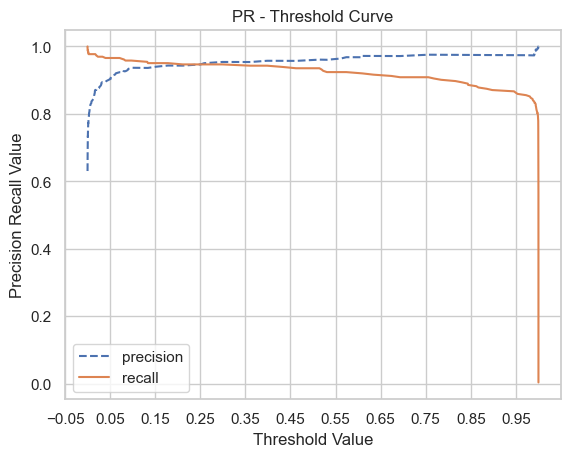

In [43]:
plot_precision_recall_threshold_curve(y_true, y_prob)

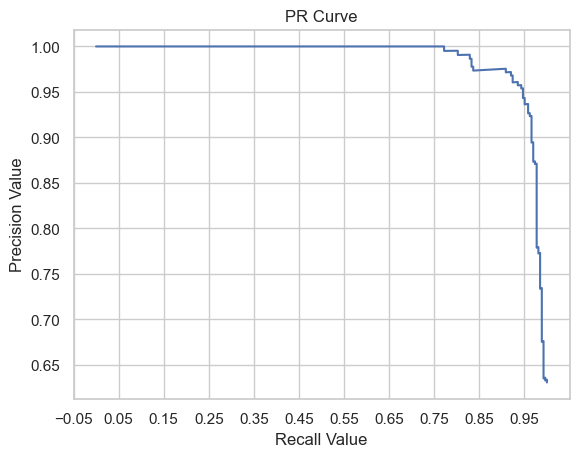

In [44]:
plot_precision_recall_curve(y_true, y_prob)

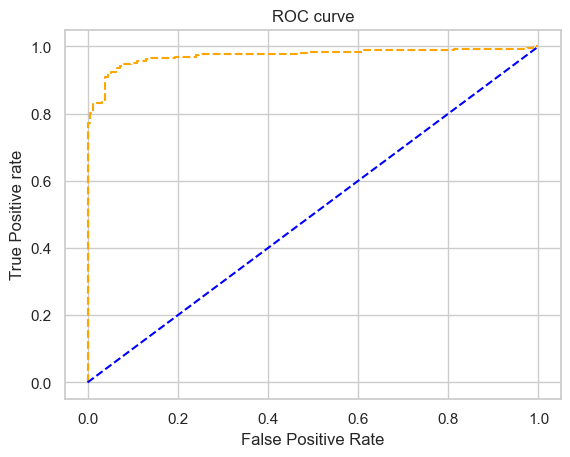

In [45]:
plot_roc_curve(y_true, y_prob)

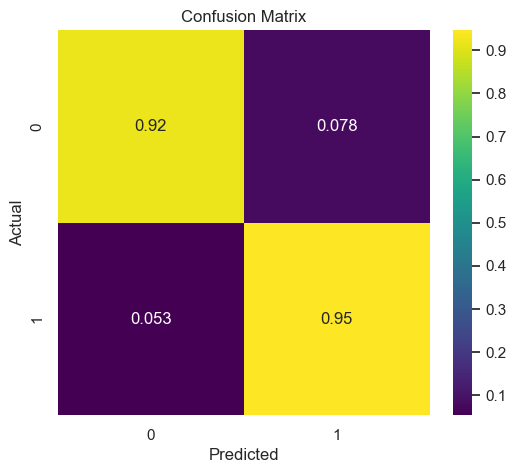

In [46]:
plot_confusion_matrix(y_true, y_pred)

# Model Comparison

In [11]:
best_rf = RandomForestClassificationModel.load("./model/rf_model")
best_gbt = GBTClassificationModel.load("./model/gbt_model")
best_xgb = SparkXGBClassifierModel.load("./model/xgb_model")
best_lgbm = LightGBMClassificationModel.load("./model/lgbm_model")

In [12]:
test_predictions_rf = best_rf.transform(testData)
test_predictions_gbt = best_gbt.transform(testData)
test_predictions_xgb = best_xgb.transform(testData)
test_predictions_lgbm = best_lgbm.transform(testData)

In [13]:
y_true_rf, y_pred_rf, y_prob_rf = spark_prediction_to_numpy(test_predictions_rf)
y_true_gbt, y_pred_gbt, y_prob_gbt = spark_prediction_to_numpy(test_predictions_gbt)
y_true_xgb, y_pred_xgb, y_prob_xgb = spark_prediction_to_numpy(test_predictions_xgb)
y_true_lgbm, y_pred_lgbm, y_prob_lgbm = spark_prediction_to_numpy(test_predictions_lgbm)

2024-08-18 20:58:31,977 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


In [41]:
columns = ["Model", "F1", "Accuracy", "Precision", "Recall"]

results = [
    ("Random Forest", f1_score(y_true_rf, y_pred_rf), accuracy_score(y_true_rf, y_pred_rf), precision_score(y_true_rf, y_pred_rf), recall_score(y_true_rf, y_pred_rf)),
    ("Gradient Boosting", f1_score(y_true_gbt, y_pred_gbt), accuracy_score(y_true_gbt, y_pred_gbt), precision_score(y_true_gbt, y_pred_gbt), recall_score(y_true_gbt, y_pred_gbt)),
    ("XGBoost", f1_score(y_true_xgb, y_pred_xgb), accuracy_score(y_true_xgb, y_pred_xgb), precision_score(y_true_xgb, y_pred_xgb), recall_score(y_true_xgb, y_pred_xgb)),
    ("LightGBM", f1_score(y_true_lgbm, y_pred_lgbm), accuracy_score(y_true_lgbm, y_pred_lgbm), precision_score(y_true_lgbm, y_pred_lgbm), recall_score(y_true_lgbm, y_pred_lgbm))
]

In [42]:
results_df = pd.DataFrame(results, columns=columns).sort_values("F1", ascending=False)
results_df

,Model,F1,Accuracy,Precision,Recall
3,LightGBM,0.950382,0.937650,0.954023,0.946768
2,XGBoost,0.946154,0.932854,0.957198,0.935361
1,Gradient Boosting,0.937143,0.920863,0.938931,0.935361
0,Random Forest,0.888031,0.860911,0.901961,0.874525


In [38]:
best_threshold_rf = get_best_threshold(y_true_rf, y_prob_rf)
best_threshold_gbt = get_best_threshold(y_true_gbt, y_prob_gbt)
best_threshold_xgb = get_best_threshold(y_true_xgb, y_prob_xgb)
best_threshold_lgbm = get_best_threshold(y_true_lgbm, y_prob_lgbm)

Best threshold: 0.5700000000000001
Precision at best threshold: 0.9019607843137255
Recall at best threshold: 0.8745247148288974
F1 score at best threshold: 0.888030888030888
Best threshold: 0.41000000000000003
Precision at best threshold: 0.9389312977099237
Recall at best threshold: 0.935361216730038
F1 score at best threshold: 0.9371428571428572
Best threshold: 0.35000000000000003
Precision at best threshold: 0.9571984435797666
Recall at best threshold: 0.935361216730038
F1 score at best threshold: 0.9461538461538461
Best threshold: 0.26
Precision at best threshold: 0.9540229885057471
Recall at best threshold: 0.9467680608365019
F1 score at best threshold: 0.950381679389313


In [39]:
y_pred_rf = (y_prob_rf >= best_threshold_rf).astype(int)
y_pred_gbt = (y_prob_gbt >= best_threshold_gbt).astype(int)
y_pred_xgb = (y_prob_xgb >= best_threshold_xgb).astype(int)
y_pred_lgbm = (y_prob_lgbm >= best_threshold_lgbm).astype(int)

results_threshold = [
    ("Random Forest", f1_score(y_true_rf, y_pred_rf), accuracy_score(y_true_rf, y_pred_rf), precision_score(y_true_rf, y_pred_rf), recall_score(y_true_rf, y_pred_rf)),
    ("Gradient Boosting", f1_score(y_true_gbt, y_pred_gbt), accuracy_score(y_true_gbt, y_pred_gbt), precision_score(y_true_gbt, y_pred_gbt), recall_score(y_true_gbt, y_pred_gbt)),
    ("XGBoost", f1_score(y_true_xgb, y_pred_xgb), accuracy_score(y_true_xgb, y_pred_xgb), precision_score(y_true_xgb, y_pred_xgb), recall_score(y_true_xgb, y_pred_xgb)),
    ("LightGBM", f1_score(y_true_lgbm, y_pred_lgbm), accuracy_score(y_true_lgbm, y_pred_lgbm), precision_score(y_true_lgbm, y_pred_lgbm), recall_score(y_true_lgbm, y_pred_lgbm))
]

results_df_threshold = pd.DataFrame(results_threshold, columns=columns).sort_values("F1", ascending=False)
results_df_threshold

,Model,F1,Accuracy,Precision,Recall
3,LightGBM,0.950382,0.937650,0.954023,0.946768
2,XGBoost,0.946154,0.932854,0.957198,0.935361
1,Gradient Boosting,0.937143,0.920863,0.938931,0.935361
0,Random Forest,0.888031,0.860911,0.901961,0.874525


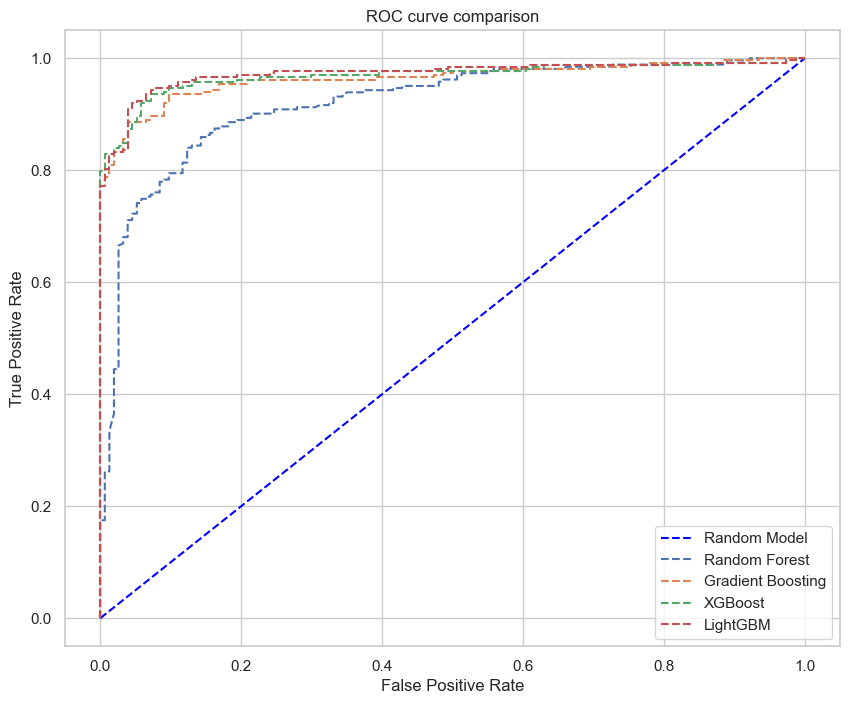

In [30]:
plt.figure(figsize=(10, 8))

plot_roc_curve(y_true_rf, y_prob_rf, label='Random Forest', color=palette[0], show_random=True)
plot_roc_curve(y_true_gbt, y_prob_gbt, label='Gradient Boosting', color=palette[1], show_random=False)
plot_roc_curve(y_true_xgb, y_prob_xgb, label='XGBoost', color=palette[2], show_random=False)
plot_roc_curve(y_true_lgbm, y_prob_lgbm, label='LightGBM', color=palette[3], show_random=False)

# Show the plot
plt.title('ROC curve comparison')
plt.show()

<b style='padding: 2px 8px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>
- From above plot we can see that Light Gradient Boosting algorithm has highest area under the curve

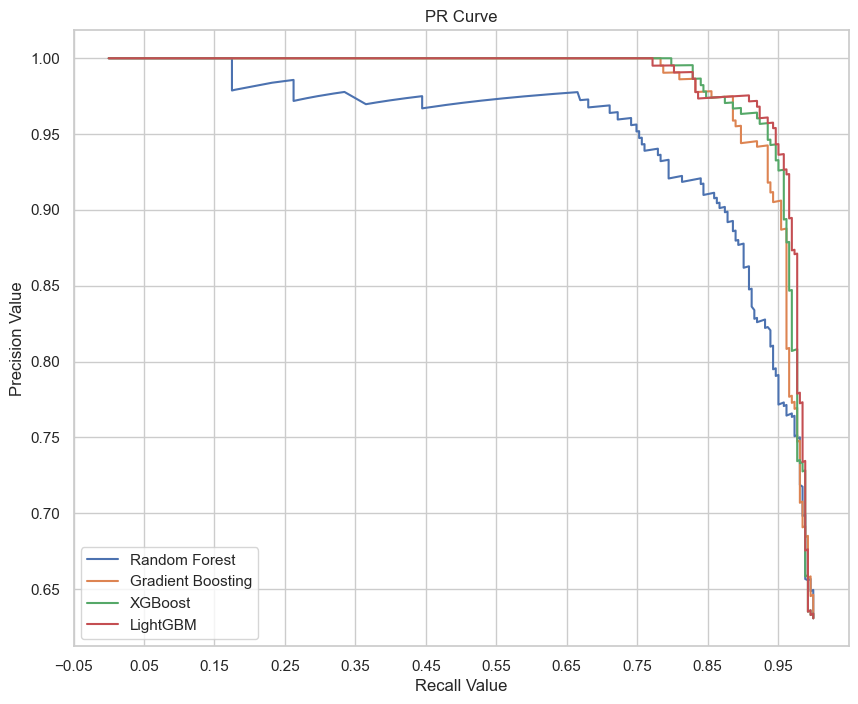

In [35]:
plt.figure(figsize=(10, 8))

plot_precision_recall_curve(y_true_rf, y_prob_rf, label='Random Forest', color=palette[0])
plot_precision_recall_curve(y_true_gbt, y_prob_gbt, label='Gradient Boosting', color=palette[1])
plot_precision_recall_curve(y_true_xgb, y_prob_xgb, label='XGBoost', color=palette[2])
plot_precision_recall_curve(y_true_lgbm, y_prob_lgbm, label='LightGBM', color=palette[3])